# Yet to decide on Train-Val check or Inner-Outer Fold check

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from latex import latexify, format_axes
import numpy as np
import tsfel
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree
import graphviz
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from MakeDataset import *
%matplotlib inline
# Retina
%config InlineBackend.figure_format = 'retina'

Training data shape:  (108, 500, 3)
Testing data shape:  (36, 500, 3)
Validation data shape:  (36, 500, 3)


In [3]:
X_train, y_train
X_test, y_test
X_val, y_val

(180, 500, 3)

### $(a_x^2 + a_y^2 + a_z^2)$

In [2]:
X_train_TS = np.sum(np.square(X_train), axis = -1)
X_test_TS = np.sum(np.square(X_test), axis = -1)
X_val_TS = np.sum(np.square(X_val), axis = -1)
print(X_train_TS.shape, X_test_TS.shape, X_val_TS.shape)

(108, 500) (36, 500) (36, 500)


In [3]:
features_sel = ["0_Mean", "0_Variance", "0_Peak to peak distance", "0_Mean absolute deviation"]

In [4]:
classesN = {1 : 'WALKING', 2 : 'WALKING_UPSTAIRS', 3 : 'WALKING_DOWNSTAIRS', 4 : 'SITTING', 5 : 'STANDING', 6 : 'LAYING'}
namedLabel = [classesN[i] for i in y_train]
classesN

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

In [5]:
def Featuriser(XTimeSeries, features):
    cfg = tsfel.get_features_by_domain()
    df = pd.DataFrame(XTimeSeries)
    dataFrames = []
    for i in df.index:
        dataFrames.append(tsfel.time_series_features_extractor(cfg, df.iloc[i,:], fs = 50))
    dfN = pd.concat(dataFrames, axis = 0)
    dfNFeaturized = dfN[features]
    return dfNFeaturized

## Featurising all the ```X_train_TS```, ```X_test_TS```, ```X_val_TS```

In [ ]:
dfTrain = Featuriser(X_train_TS, features_sel)
dfTest = Featuriser(X_test_TS, features_sel)
dfVal = Featuriser(X_val_TS, features_sel)

In [7]:
dfTrain.shape

(108, 4)

In [8]:
dfTest.shape

(36, 4)

In [9]:
dfVal.shape

(36, 4)

In [10]:
dfTrain

0_Mean  0_Variance  0_Peak to peak distance  0_Mean absolute deviation
0   1.058182    0.000441                 0.276308                   0.010239
0   1.072680    0.000439                 0.302652                   0.011554
0   1.141142    0.281282                 2.951101                   0.382585
0   1.193139    0.442850                 2.853736                   0.537589
0   1.005901    0.000026                 0.042222                   0.004003
..       ...         ...                      ...                        ...
0   1.328807    1.370835                 4.655614                   0.995502
0   1.188371    0.436127                 3.625210                   0.506932
0   1.066069    0.000026                 0.031092                   0.004027
0   1.116685    0.245975                 2.492894                   0.382408
0   1.118337    0.250313                 2.180257                   0.381846

[108 rows x 4 columns]

In [12]:
hyperparams = {"max_depth" : [2, 3, 4, 5, 6, 7, 8, 9, 10], "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}
hyperparams

{'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
 'criterion': ['gini', 'entropy'],
 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}

In [13]:
from itertools import product
final, counter = {}, 0
for max_depth, criteria, min_sample in product(hyperparams["max_depth"], hyperparams["criterion"], hyperparams["min_samples_leaf"]):
    model = DecisionTreeClassifier(max_depth = max_depth, criterion = criteria, min_samples_leaf = min_sample, random_state = 42)
    model.fit(dfTrain, y_train)
    val_score = model.score(dfVal, y_val)
    final[counter] = {"max_depth" : max_depth, "criterion" : criteria, "min_samples_leaf" : min_sample, "val_score" : val_score}
    counter += 1

In [14]:
hparam_df = pd.DataFrame(final).T
hparam_df

max_depth criterion min_samples_leaf val_score
0           2      gini                1  0.638889
1           2      gini                2  0.638889
2           2      gini                3  0.638889
3           2      gini                4  0.638889
4           2      gini                5  0.638889
..        ...       ...              ...       ...
265        10   entropy               11  0.694444
266        10   entropy               12  0.666667
267        10   entropy               13  0.666667
268        10   entropy               14  0.666667
269        10   entropy               15  0.666667

[270 rows x 4 columns]

In [15]:
hparam_df.sort_values(by = "val_score", ascending = False).head(10)

max_depth criterion min_samples_leaf val_score
136         6   entropy                2  0.777778
256        10   entropy                2  0.722222
255        10   entropy                1  0.722222
115         5   entropy               11  0.694444
130         6      gini               11  0.694444
220         9      gini               11  0.694444
241        10      gini                2  0.694444
100         5      gini               11  0.694444
250        10      gini               11  0.694444
190         8      gini               11  0.694444

In [16]:
dfTrain_Val_Test = pd.concat([dfTrain, dfVal, dfTest], axis = 0)
y_train_test_val = np.hstack([y_train, y_val, y_test])
dfTrain_Val_Test

0_Mean  0_Variance  0_Peak to peak distance  0_Mean absolute deviation
0   1.058182    0.000441                 0.276308                   0.010239
0   1.072680    0.000439                 0.302652                   0.011554
0   1.141142    0.281282                 2.951101                   0.382585
0   1.193139    0.442850                 2.853736                   0.537589
0   1.005901    0.000026                 0.042222                   0.004003
..       ...         ...                      ...                        ...
0   1.012756    0.000036                 0.046293                   0.004625
0   1.029612    0.000035                 0.055289                   0.004476
0   1.221348    0.614296                 3.526818                   0.662692
0   1.168859    0.455832                 3.239159                   0.501238
0   1.159747    0.317845                 2.934196                   0.436656

[180 rows x 4 columns]

In [17]:
model = DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 2, criterion = "entropy", random_state = 42)
model.fit(dfTrain_Val_Test, y_train_test_val)

DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=2,
                       random_state=42)

In [18]:
def getTimeSeries(filename):
    filePath = f"./Time Series Data/{filename}"
    df = pd.read_csv(filePath)
    return df

In [19]:
df = getTimeSeries('TS2Walking.csv')
df

time     gFx     gFy     gFz      0
0       0.004371 -0.9965  0.1796  0.2842  1.068
1       0.005229 -1.0007  0.1845  0.2910  1.075
2       0.005670 -1.0034  0.1886  0.2964  1.080
3       0.006074 -1.0026  0.1903  0.2984  1.080
4       0.006489 -0.9985  0.1920  0.2954  1.076
...          ...     ...     ...     ...    ...
19310  38.514996 -0.9303 -0.0344  0.4249  1.032
19311  38.516256 -0.9301 -0.0349  0.4234  1.031
19312  38.518234 -0.9315 -0.0347  0.4222  1.032
19313  38.520242 -0.9335 -0.0354  0.4229  1.034
19314  38.522770 -0.9354 -0.0364  0.4251  1.037

[19315 rows x 5 columns]

In [20]:
def fetchTotTS(dataFrame):
    return pd.DataFrame(dataFrame.iloc[:, 4]**2)

In [21]:
def PlotTimeSeries(df, flag):
    latexify()
    if flag:
        plt.figure(figsize = (9, 3))
        plt.title(r"Time Series of Acceleration $(acc_x, acc_y, acc_z)$")
        colors = ["red", "green", "blue"]
        for k in range(1, 4):
            plt.plot(df.iloc[:, k], color = colors[k - 1], linewidth = 0.8)
        plt.xlabel("Time Samples")
        plt.ylabel(r"Acceleration in $m/s^2$")
        plt.legend([r"$a_x$", r"$a_y$", r"$a_z$"])
        plt.grid()
        plt.show()
    else:
        plt.figure(figsize = (9, 3))
        plt.title(r"Time Series of Total Acceleration $(acc_x^2 + acc_y^2 + acc_z^2)$")
        plt.plot(df.iloc[:, 4]**2, color = "deeppink", linewidth = 0.8)
        plt.xlabel("Time Samples")
        plt.ylabel(r"Total Acceleration in $m/s^2$")
        plt.legend([r"$(acc_x^2 + acc_y^2 + acc_z^2)$"])
        plt.grid()
        plt.show()

### $\text{Sampling Time} = \frac{\text{No. of Samples}}{f_s}$
### $f_s = 500 Hz$

In [22]:
df.shape[0] / 500.0

38.63

In [23]:
def FeaturiserN(XTimeSeries, features):
    model1 = tsfel.get_features_by_domain()
    df = pd.DataFrame(XTimeSeries).T
    dfN = tsfel.time_series_features_extractor(model1, signal_windows = list(df.iloc[0, :]), fs = 50)
    dfNFeaturized = dfN[features]
    return dfNFeaturized

In [24]:
pd.DataFrame(fetchTotTS(df.iloc[2500:7500, :])).T

2500      2501      2502      2503      2504      2505      2506   
0  0.751689  0.755161  0.758641  0.765625  0.776161  0.786769  0.799236  \

       2507      2508    2509  ...      7490      7491      7492      7493   
0  0.808201  0.817216  0.8281  ...  1.646089  1.565001  1.517824  1.485961  \

       7494      7495    7496      7497      7498      7499  
0  1.452025  1.420864  1.3924  1.364224  1.331716  1.301881  

[1 rows x 5000 columns]

In [25]:
dfN1 = FeaturiserN(fetchTotTS(df.iloc[2500:7500, :]), features_sel)
dfN1

*** Feature extraction started ***



*** Feature extraction finished ***


0_Mean  0_Variance  0_Peak to peak distance  0_Mean absolute deviation
0  1.18036     0.49156                 3.675776                   0.540058

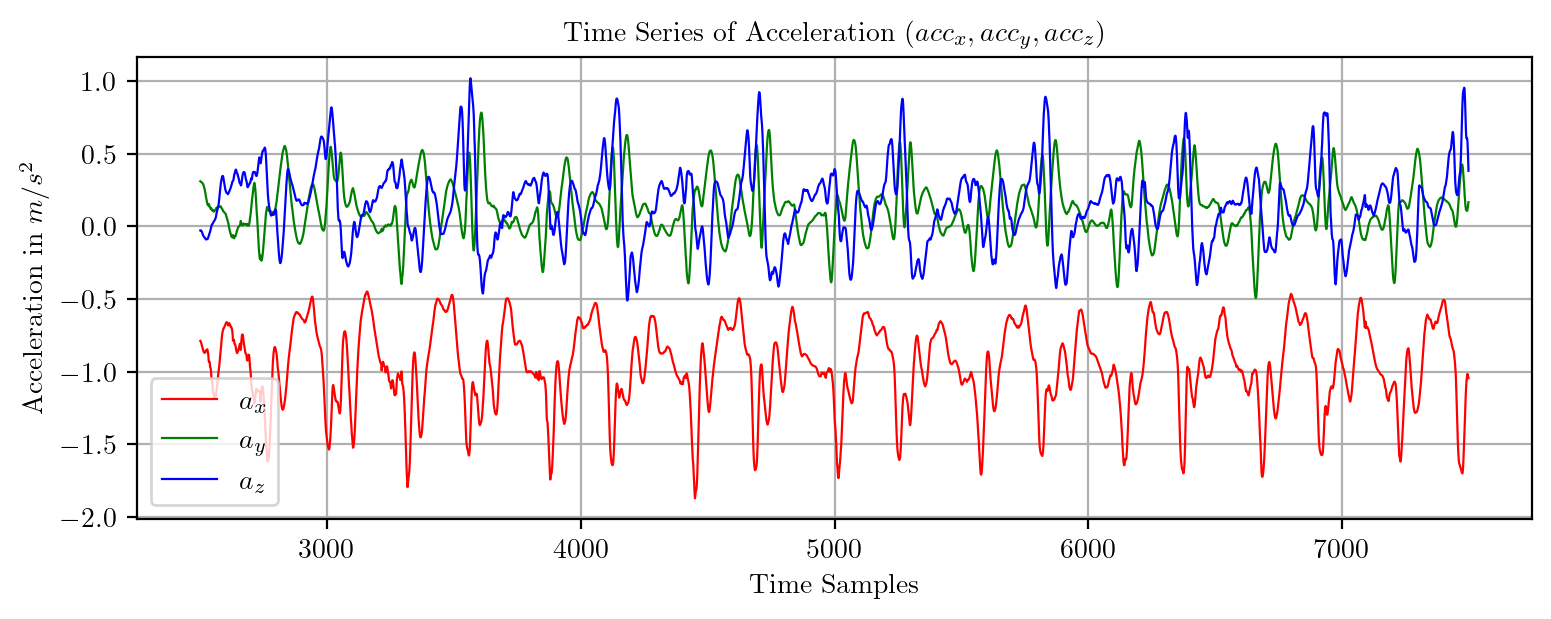

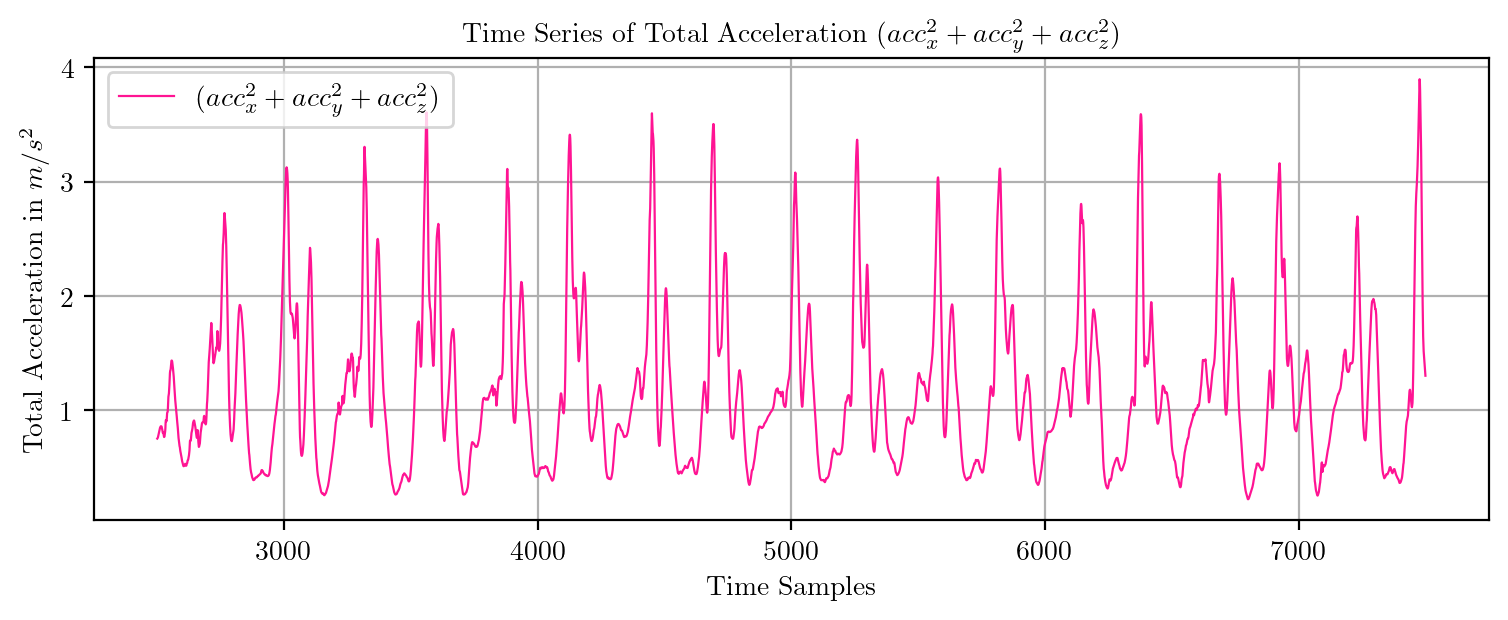

In [26]:
PlotTimeSeries(df.iloc[2500:7500,:], 1)
PlotTimeSeries(df.iloc[2500:7500,:], 0)

In [27]:
y_pred = model.predict(dfN1)
y_pred

array([2])

In [28]:
classesN

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

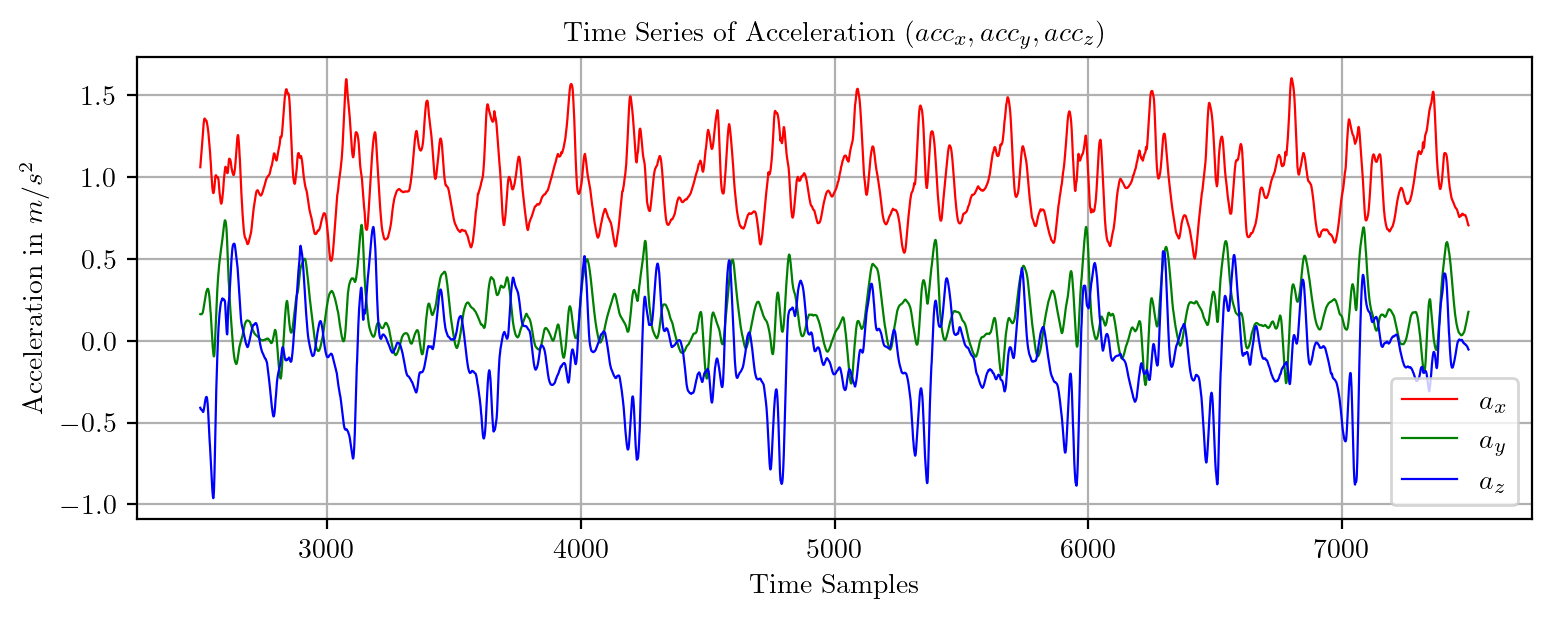

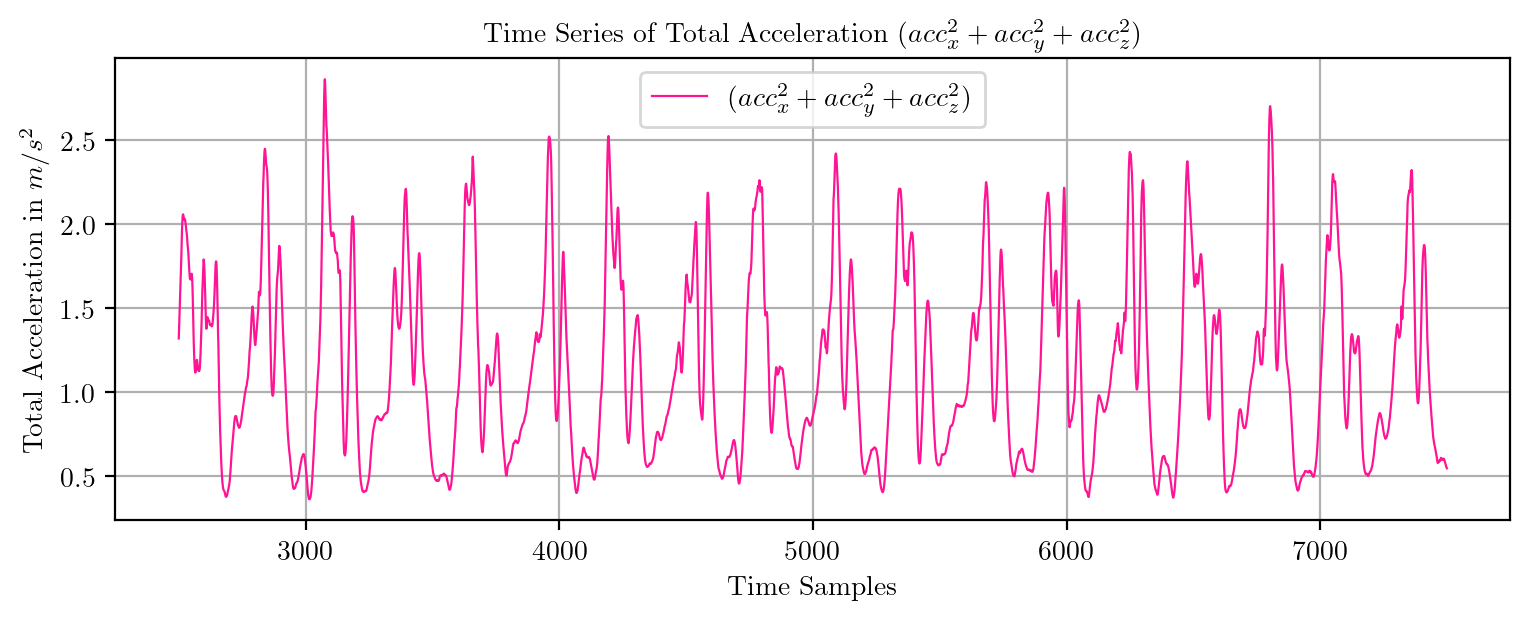

*** Feature extraction started ***



*** Feature extraction finished ***


'WALKING'

In [29]:
df1 = getTimeSeries('TS4Walking.csv')
DF = df1.iloc[2500:7500, :]
PlotTimeSeries(DF, 1)
PlotTimeSeries(DF, 0)
dfN2 = FeaturiserN(fetchTotTS(DF), features_sel)
y_pred = model.predict(dfN2)
classesN[y_pred[0]]

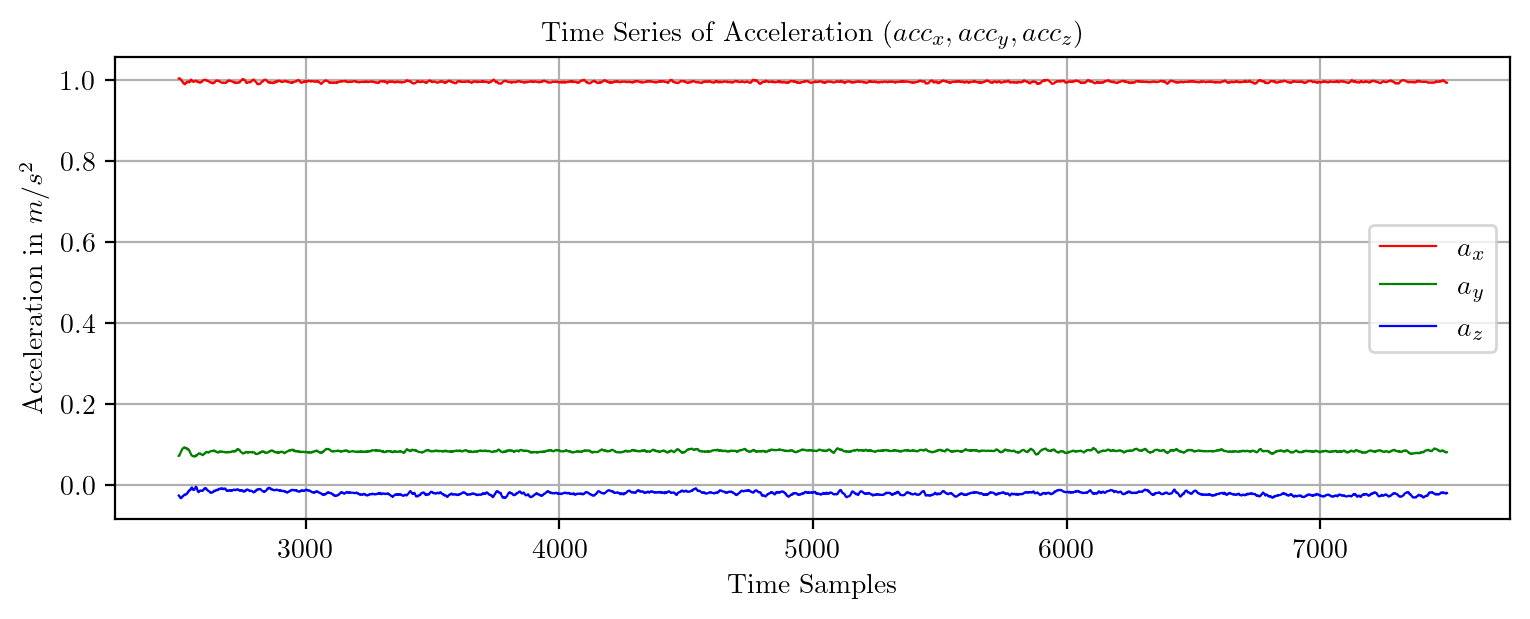

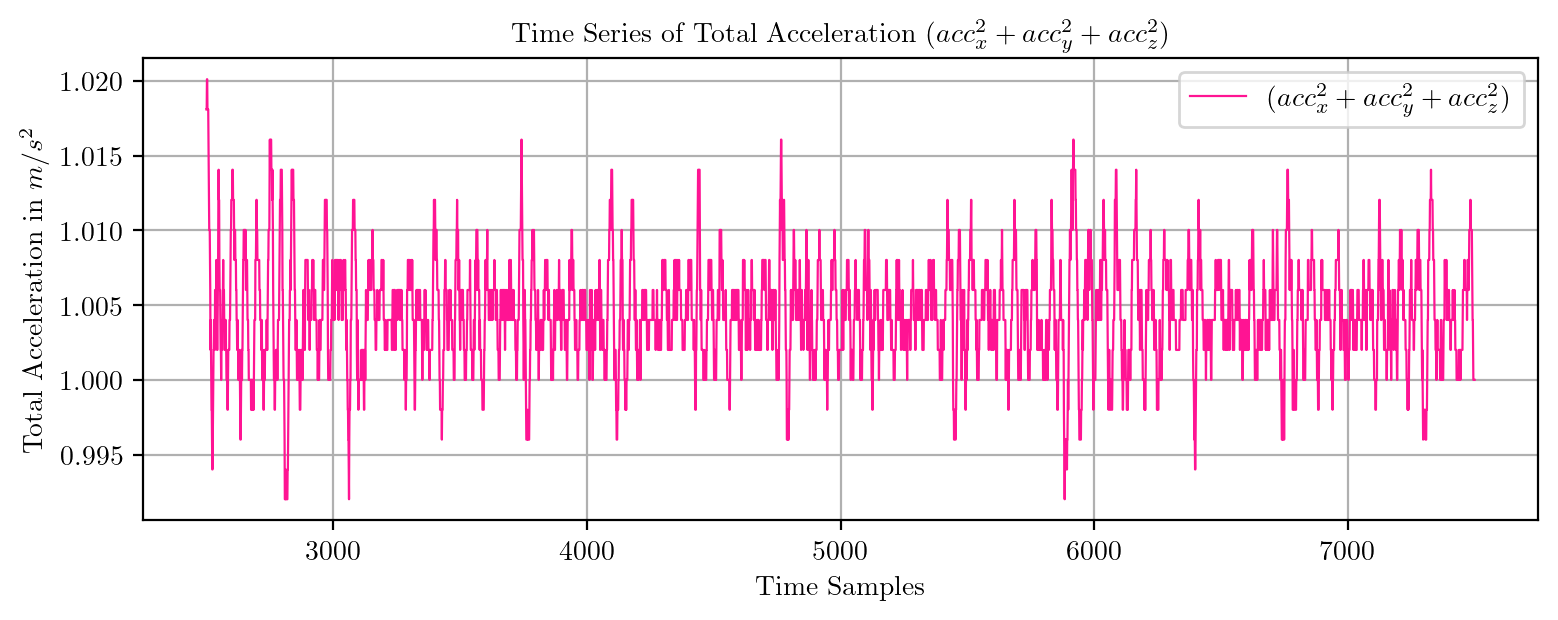

*** Feature extraction started ***



*** Feature extraction finished ***


'SITTING'

In [30]:
df2 = getTimeSeries('TS10Sitting.csv')
DF = df2.iloc[2500:7500, :]
PlotTimeSeries(DF, 1)
PlotTimeSeries(DF, 0)
dfN3 = FeaturiserN(fetchTotTS(DF), features_sel)
y_pred = model.predict(dfN3)
classesN[y_pred[0]]

In [31]:
# flag = 1 -> Only display the orginal untrimmed TS and trim-prediction on flag != 1
def PredictPlot(filename,  flag = 1, start = None, end = None):
    df = getTimeSeries(filename)
    if flag:
        print("Original Time Series")
        PlotTimeSeries(df, 1)
        PlotTimeSeries(df, 0)
    else:
        DF = df.iloc[start : end, :]
        print("Trimmed Time Series")
        PlotTimeSeries(DF, 1)
        PlotTimeSeries(DF, 0)
        dfN = FeaturiserN(fetchTotTS(DF), features_sel)
        y_pred = model.predict(dfN)
        print(classesN[y_pred[0]])

Original Time Series


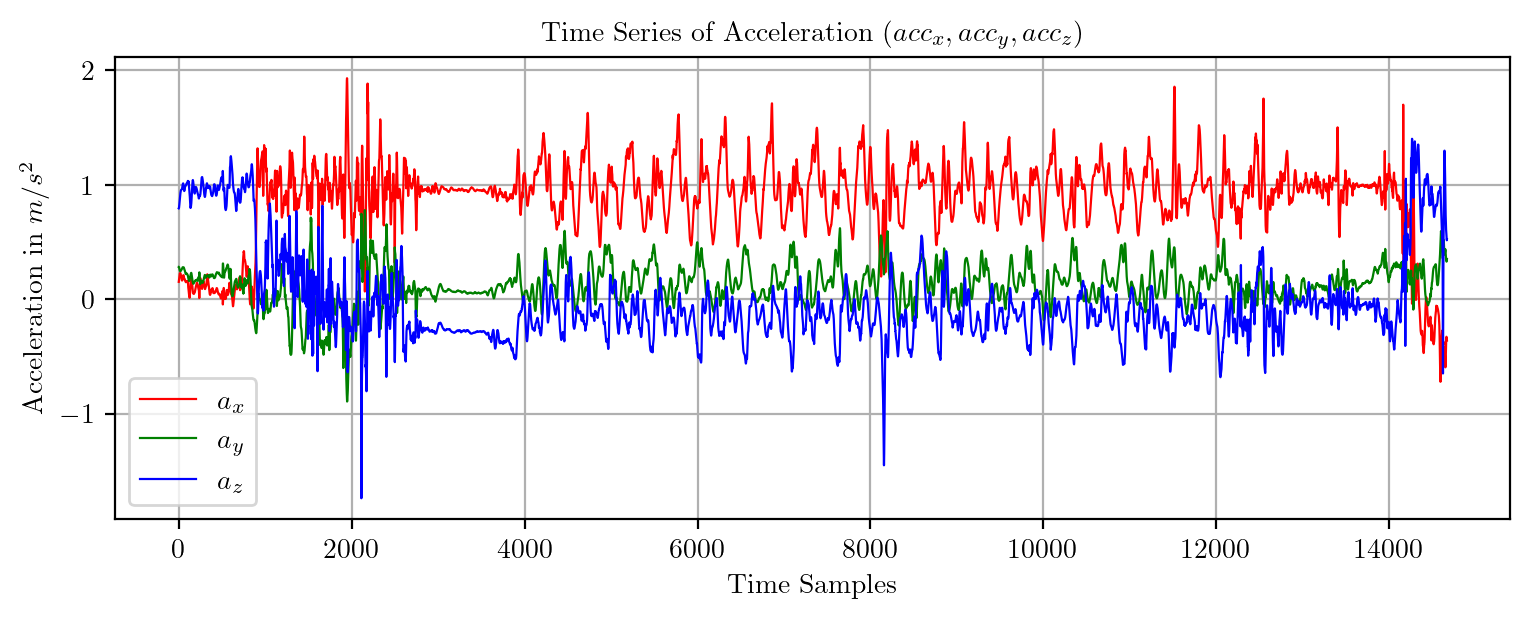

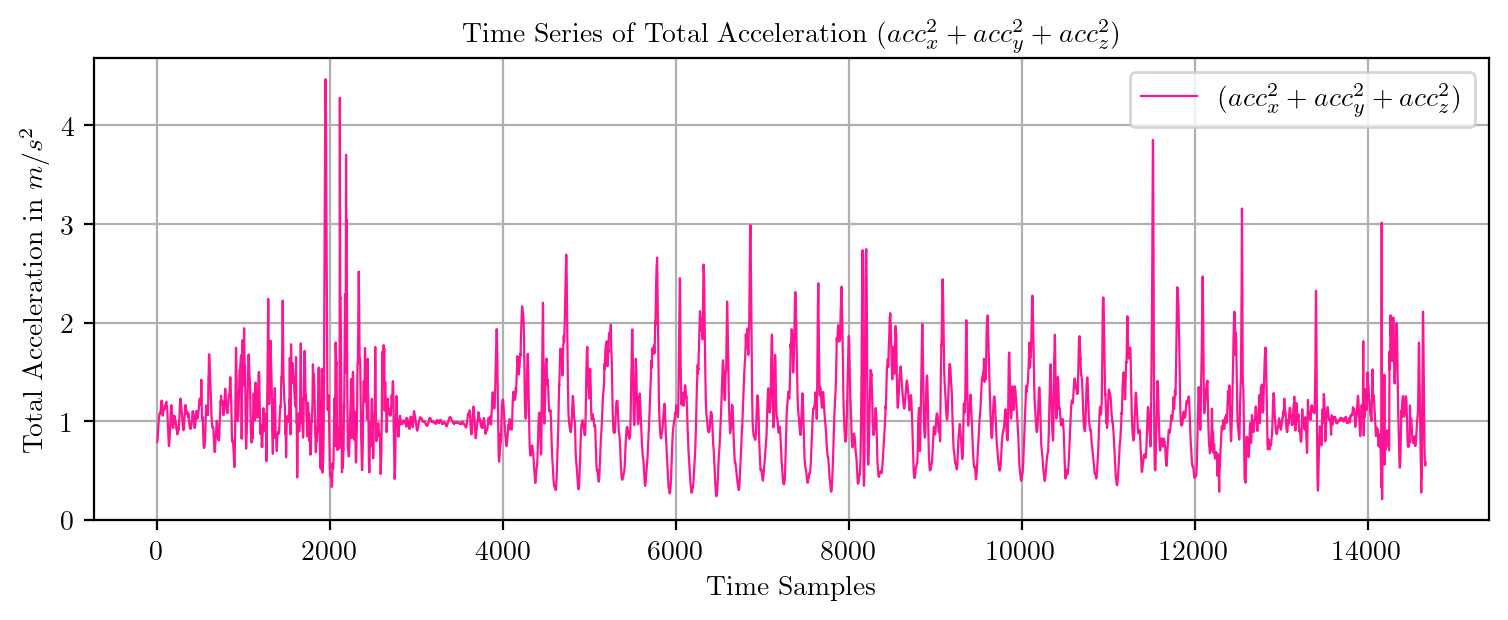

In [32]:
PredictPlot("TS5WalkingUpstairs.csv", 1)

Trimmed Time Series


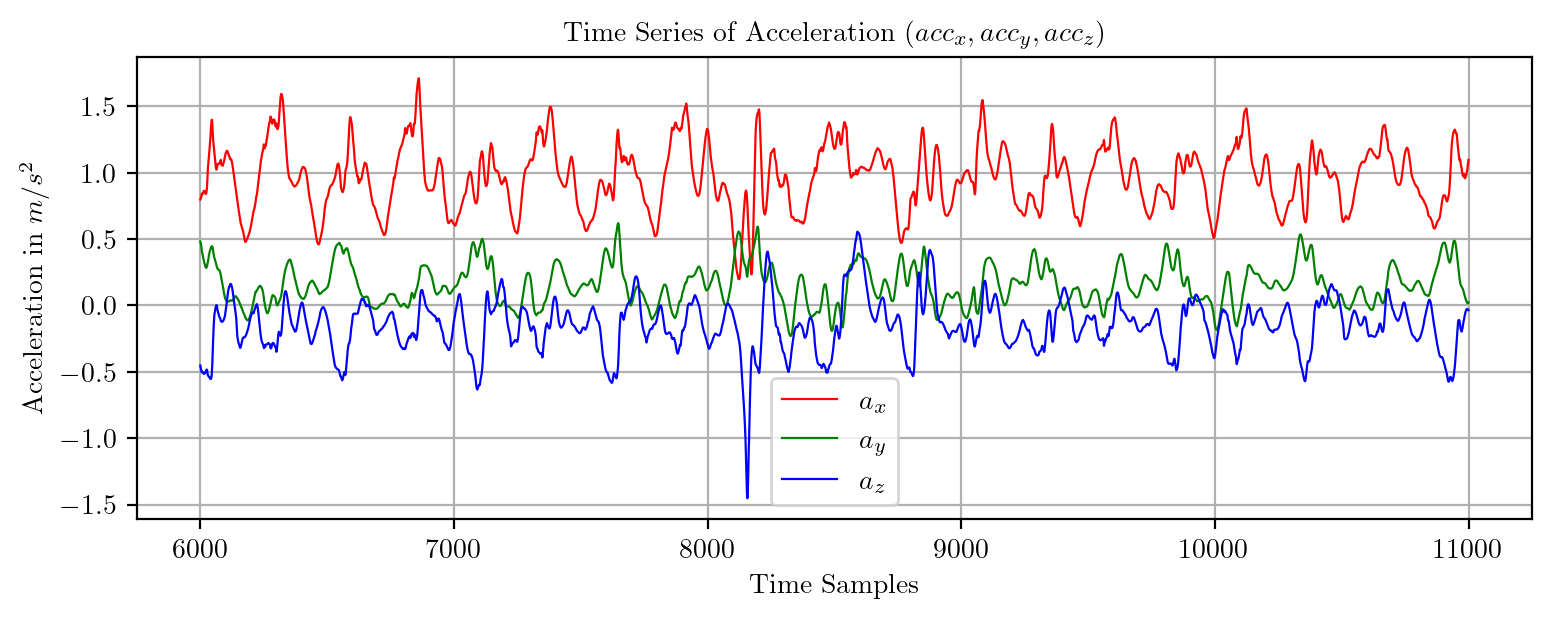

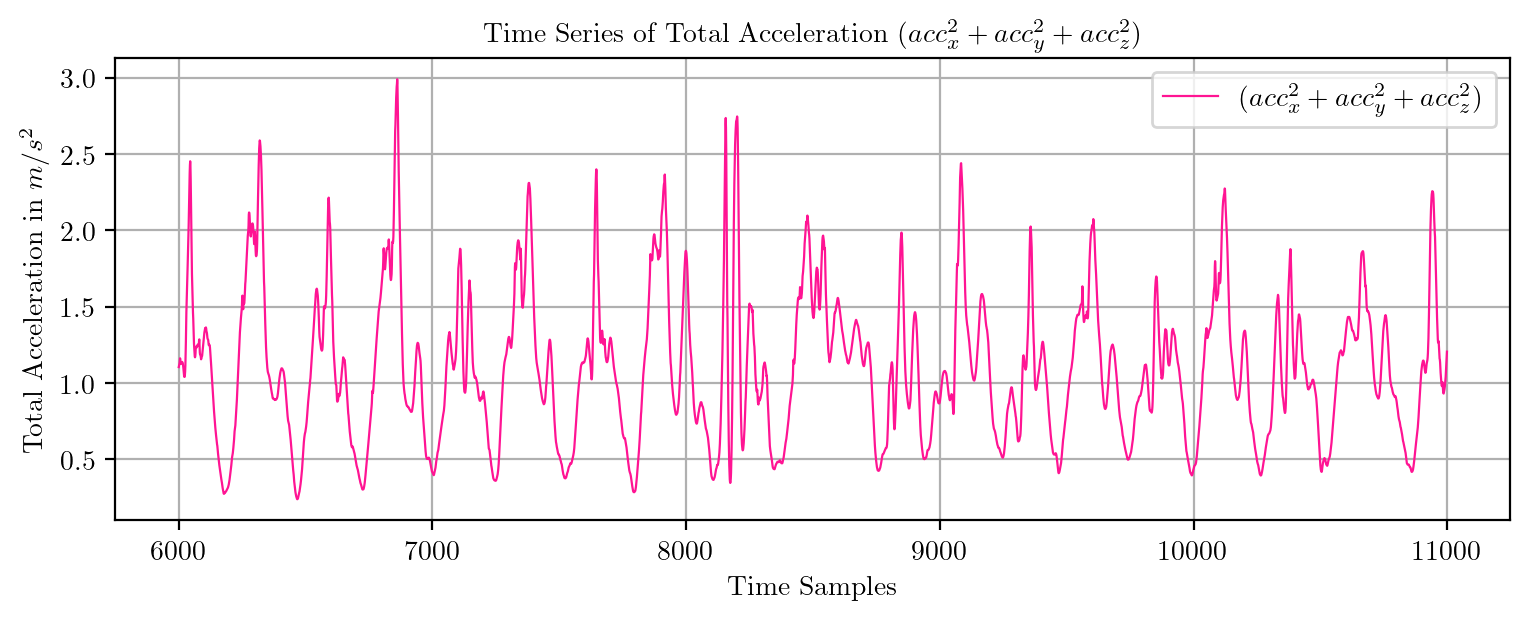

*** Feature extraction started ***



*** Feature extraction finished ***
WALKING_UPSTAIRS


In [33]:
PredictPlot("TS5WalkingUpstairs.csv", 0, 6000, 11000)

Original Time Series


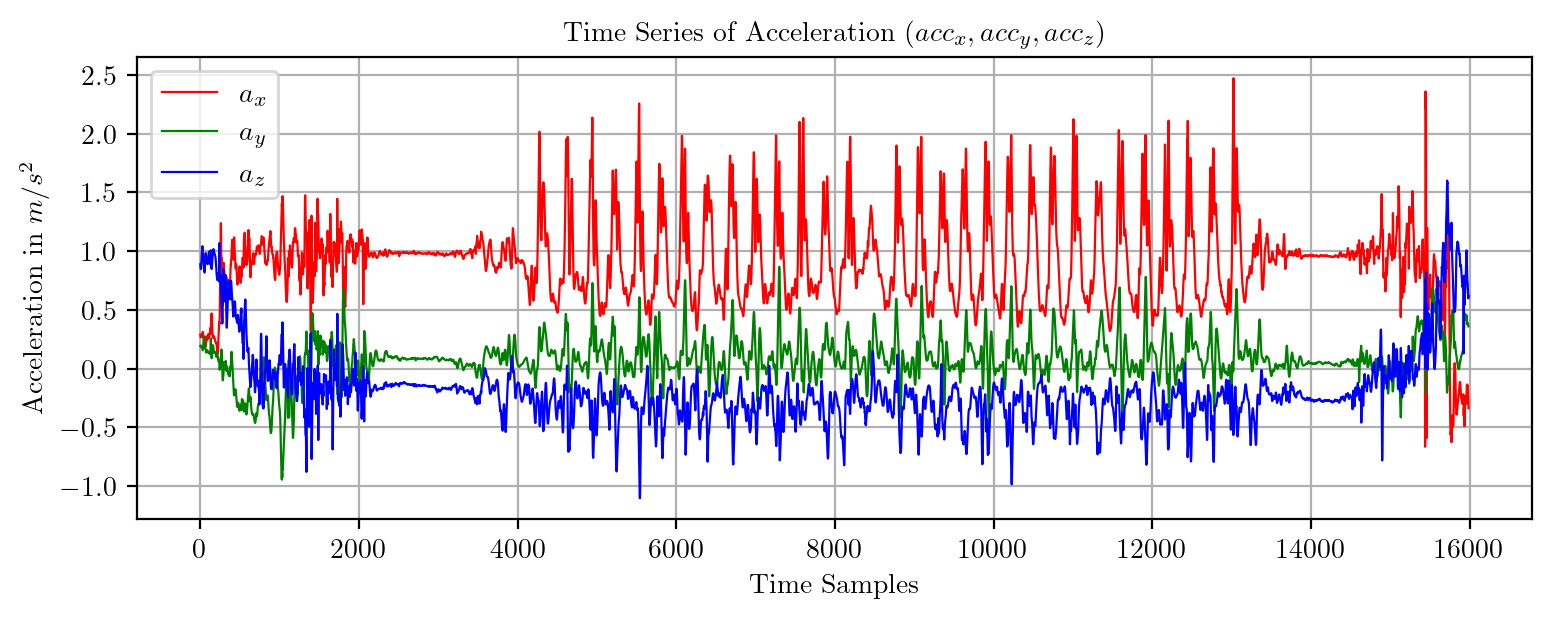

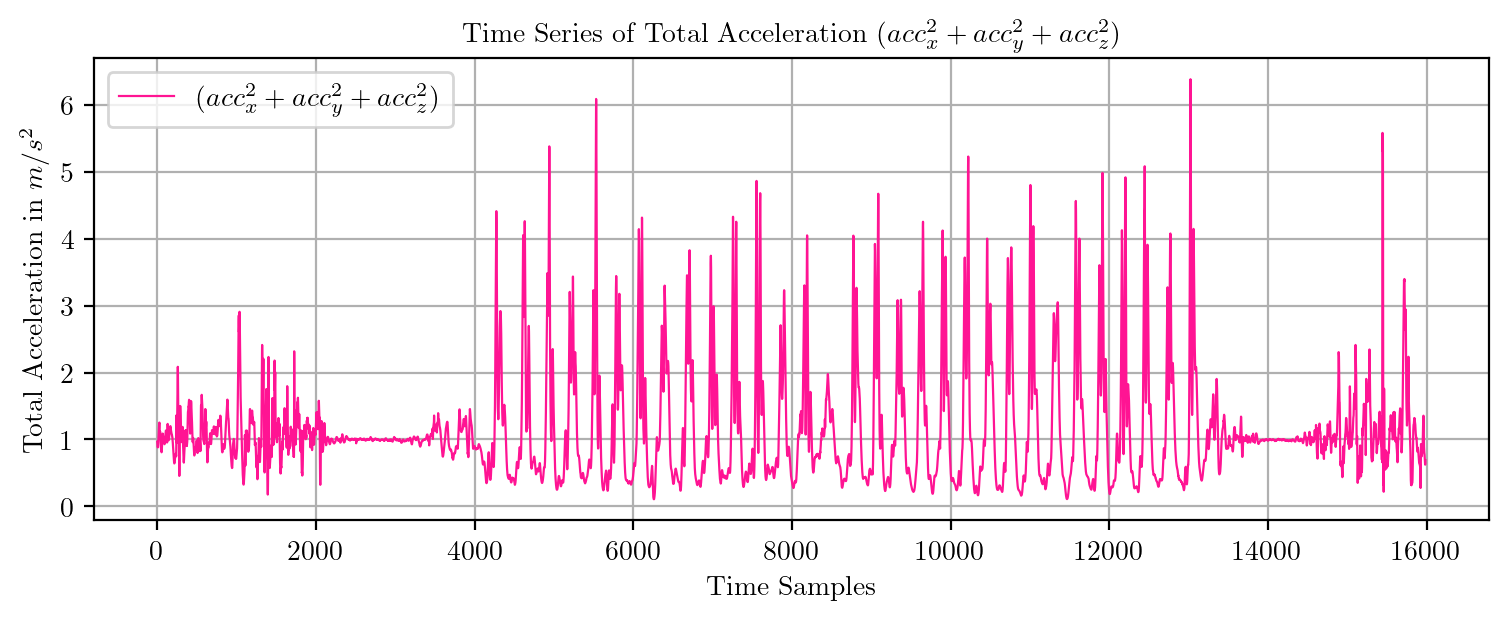

In [34]:
PredictPlot("TS6WalkingDownstairs.csv", 1)

Trimmed Time Series


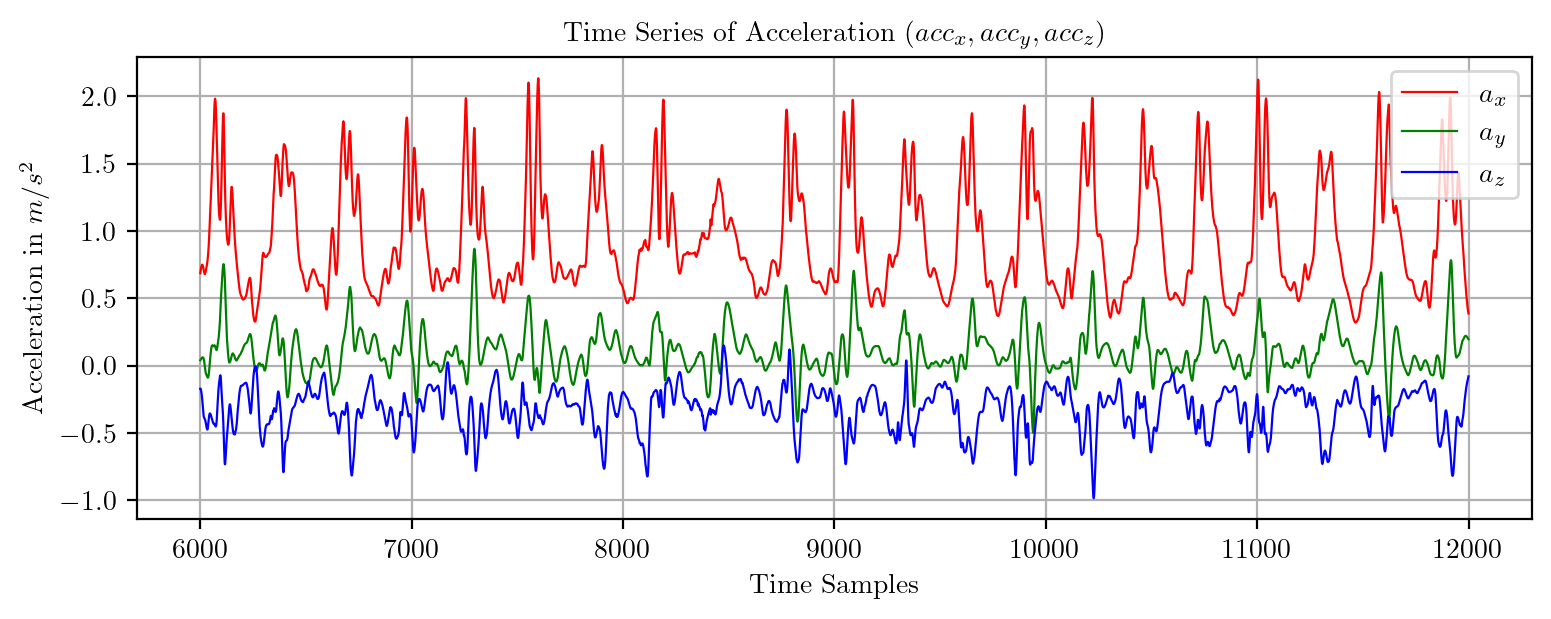

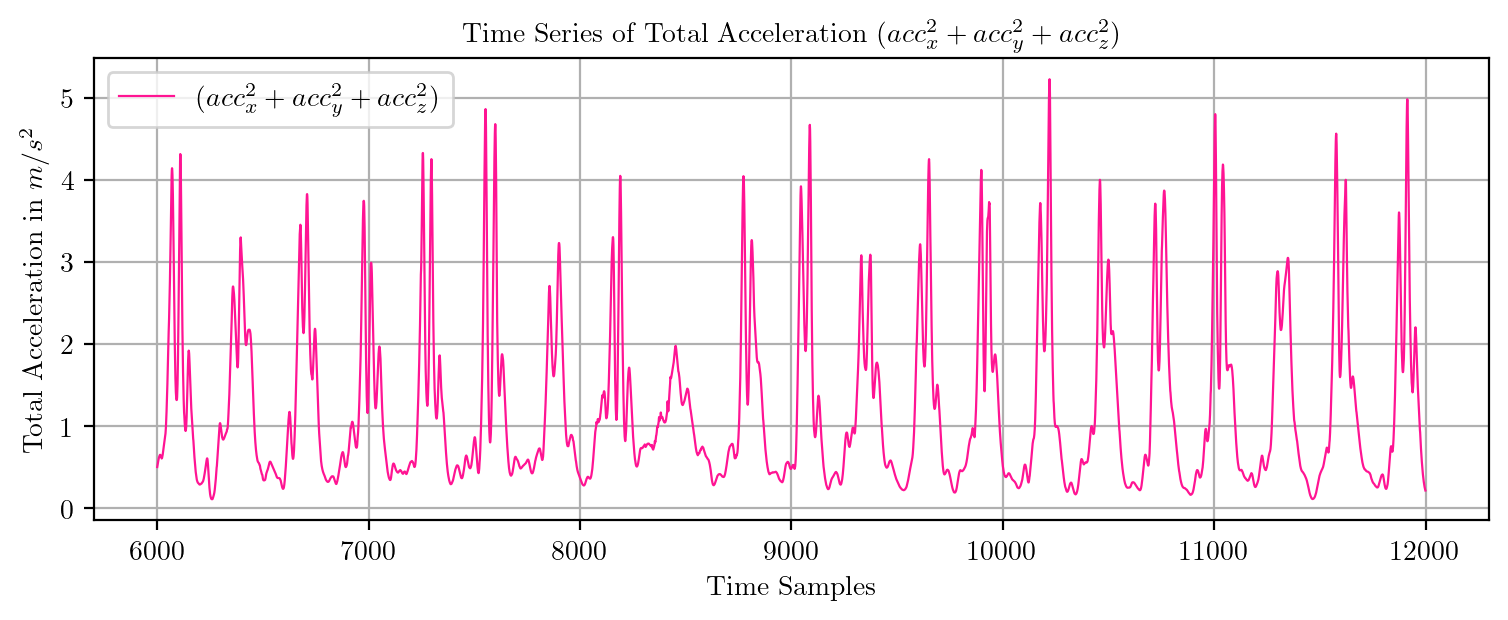

*** Feature extraction started ***



*** Feature extraction finished ***
WALKING_DOWNSTAIRS


In [35]:
PredictPlot("TS6WalkingDownstairs.csv", 0, 6000, 12000)

Original Time Series


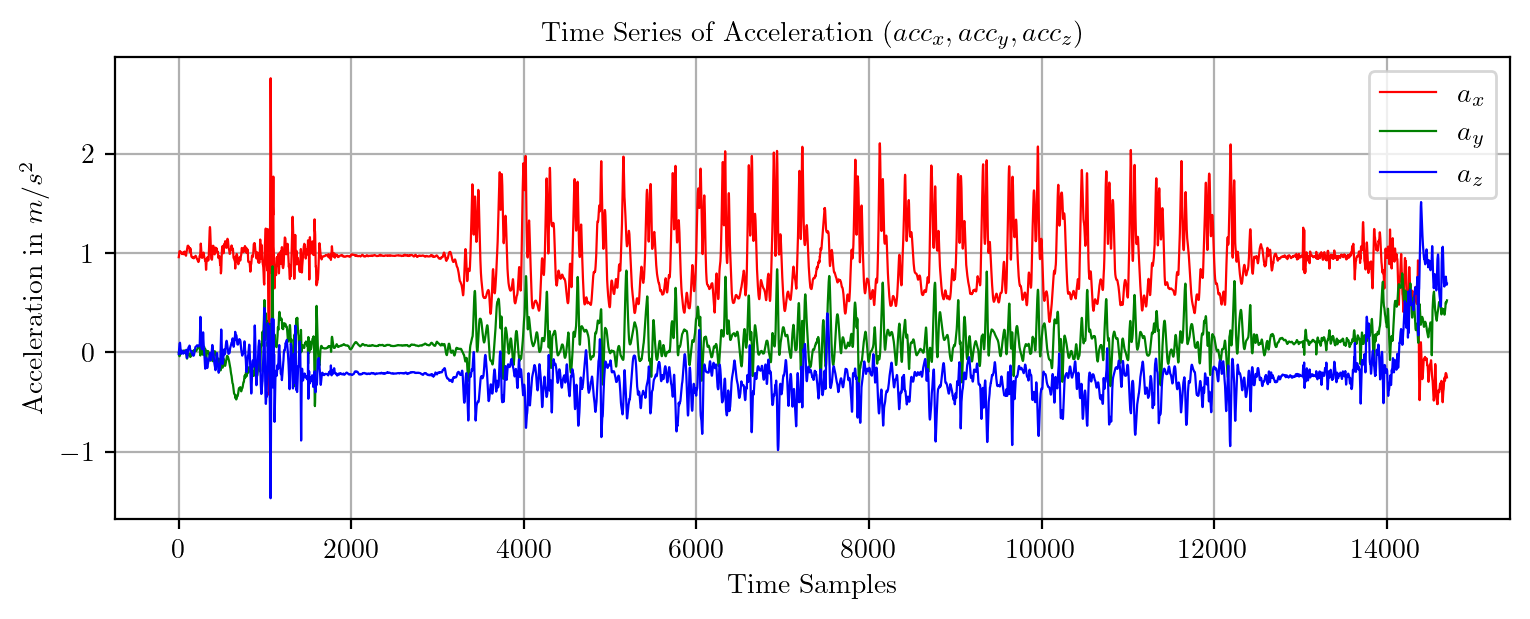

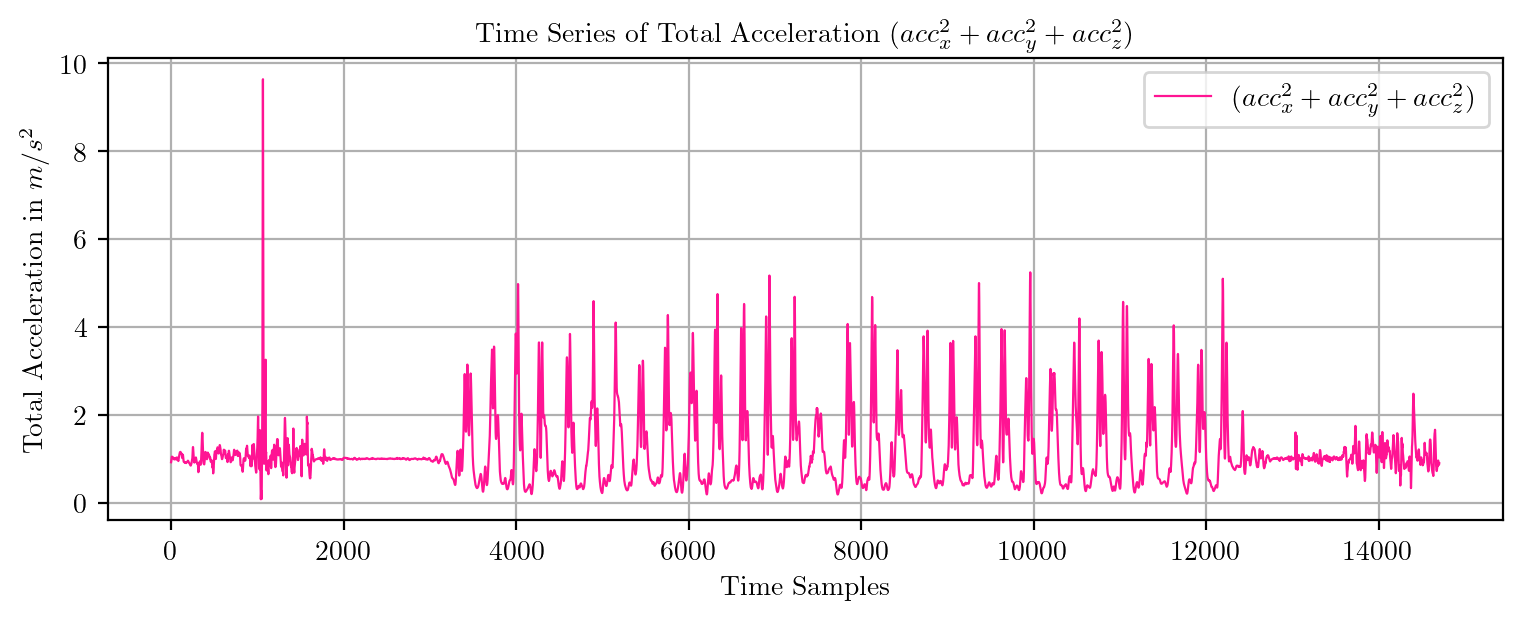

In [36]:
PredictPlot("TS7WalkingDownstairs.csv", 1)

Trimmed Time Series


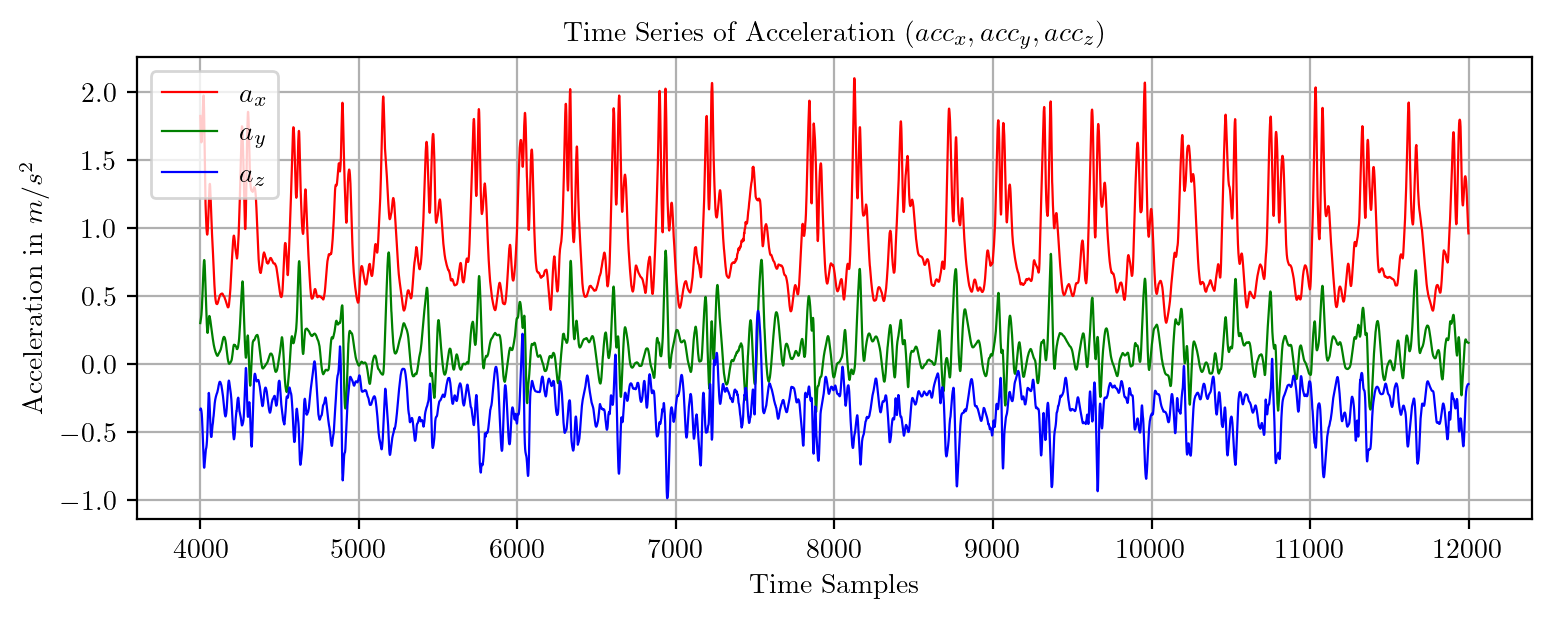

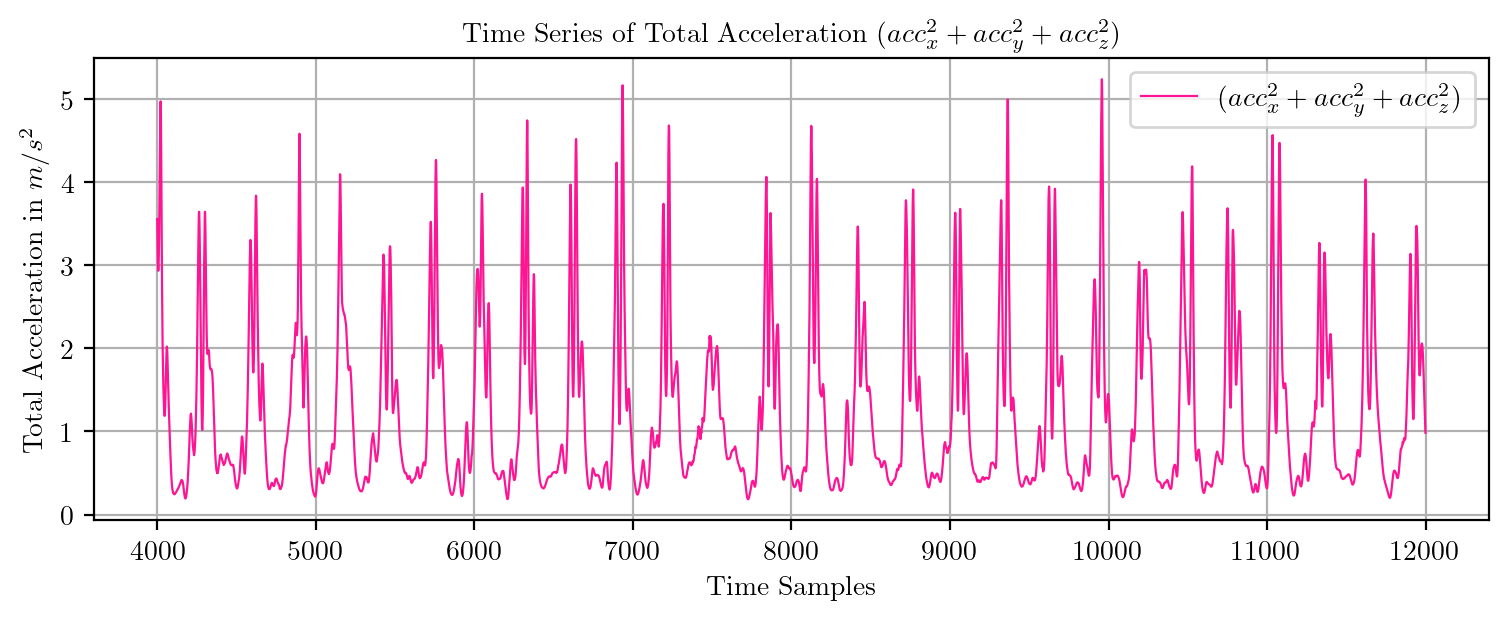

*** Feature extraction started ***



*** Feature extraction finished ***
WALKING_DOWNSTAIRS


In [37]:
PredictPlot("TS7WalkingDownstairs.csv", 0, 4000, 12000)

Original Time Series


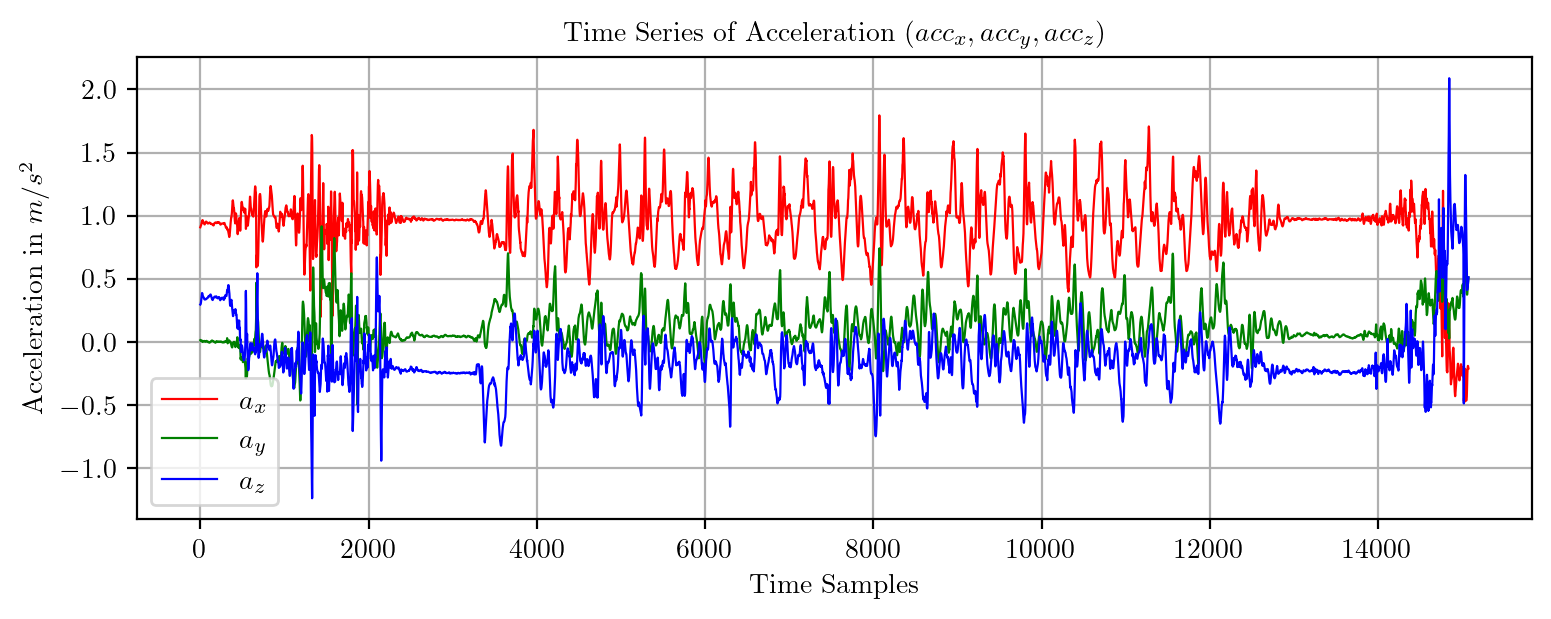

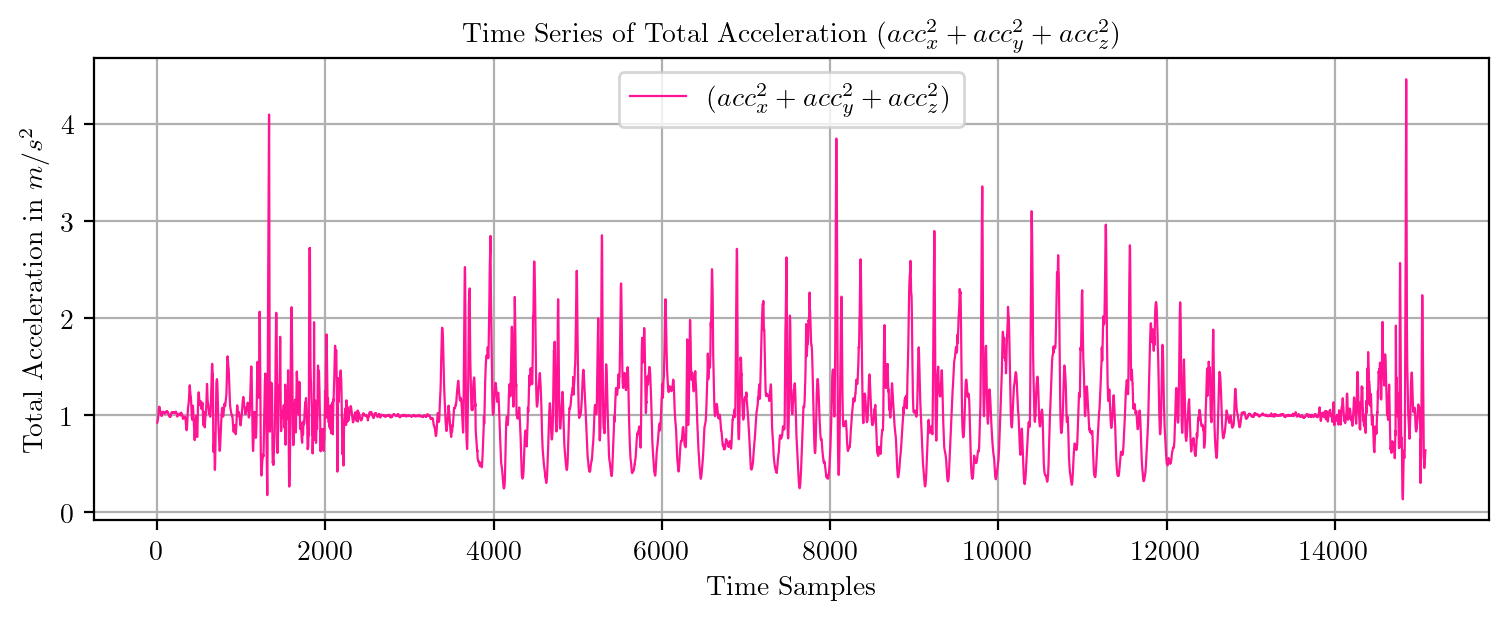

In [38]:
PredictPlot("TS8WalkingUpstairs.csv", 1)

Trimmed Time Series


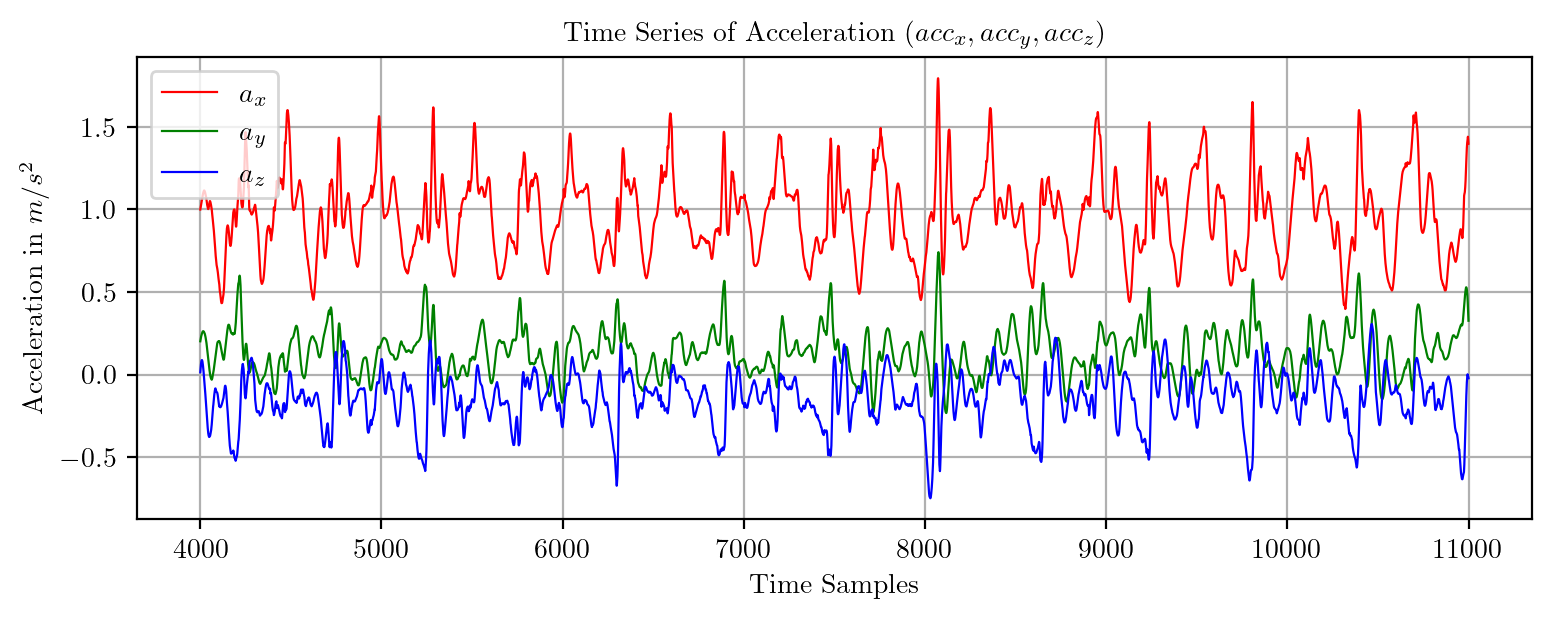

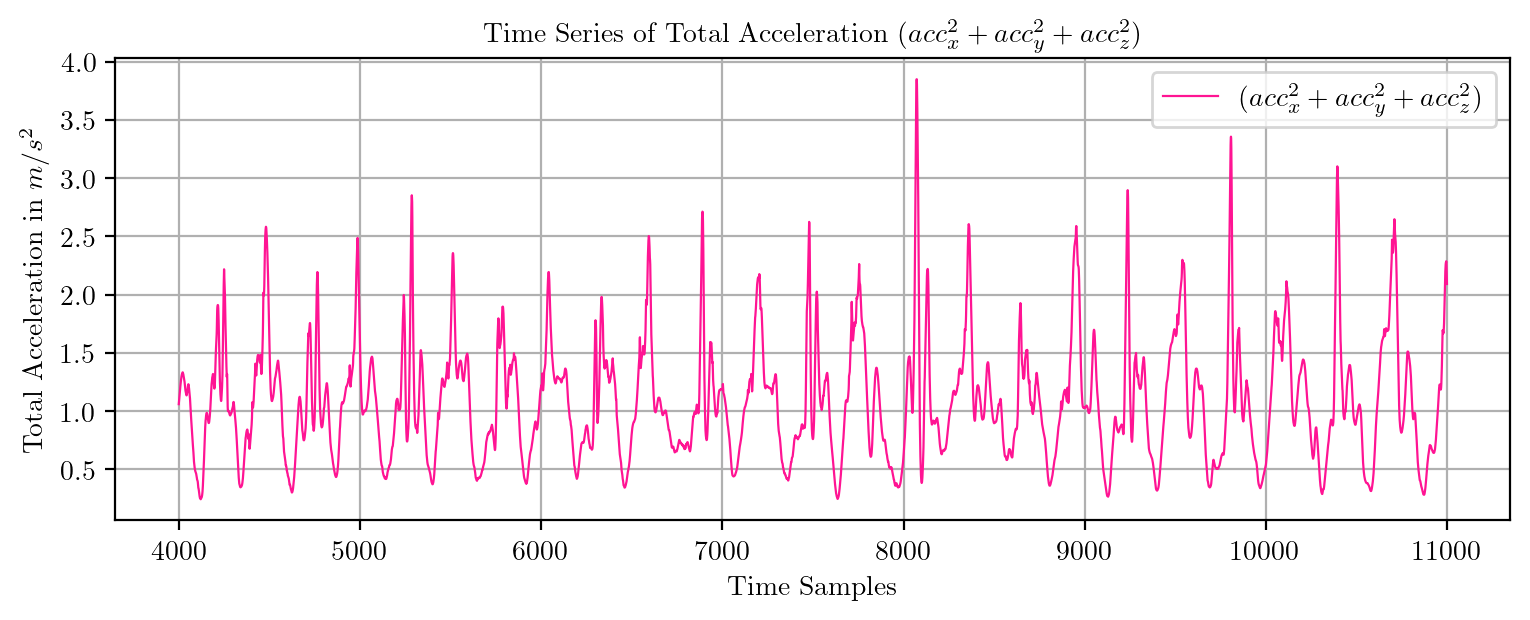

*** Feature extraction started ***



*** Feature extraction finished ***
STANDING


In [39]:
PredictPlot("TS8WalkingUpstairs.csv", 0, 4000, 11000)

Original Time Series


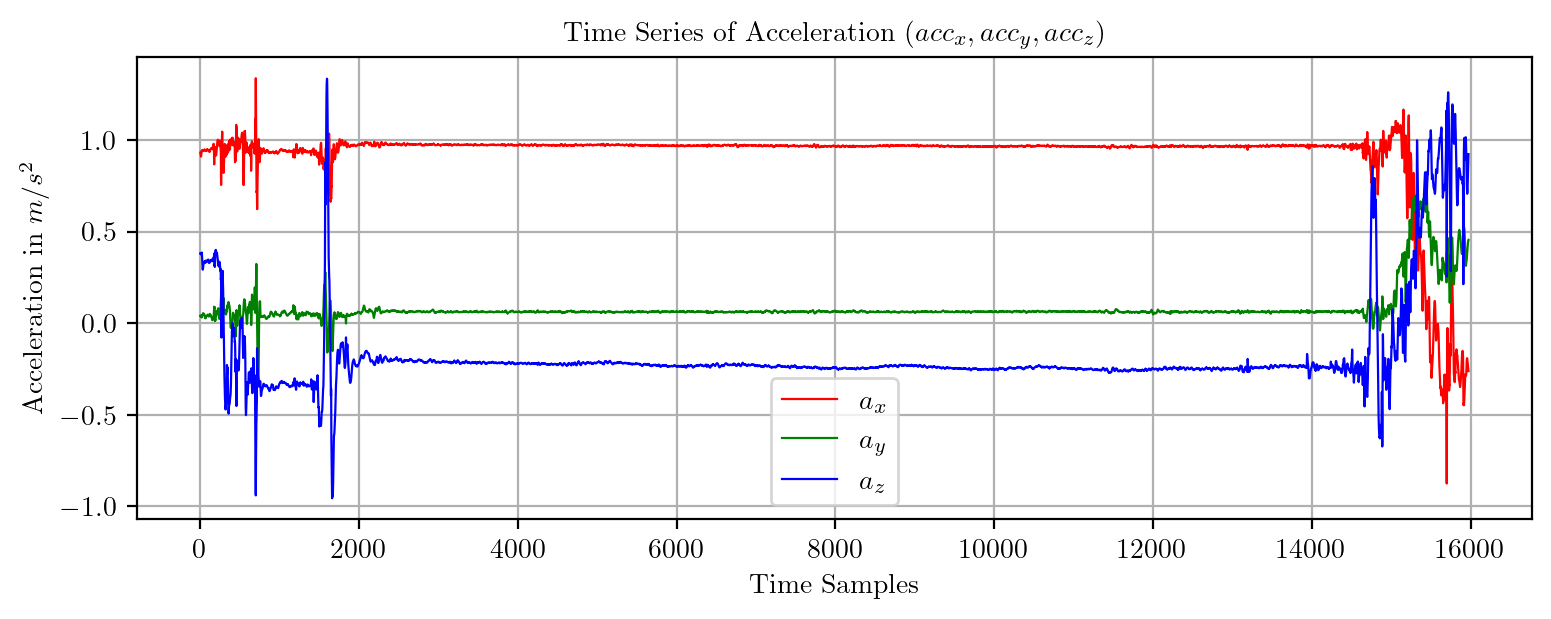

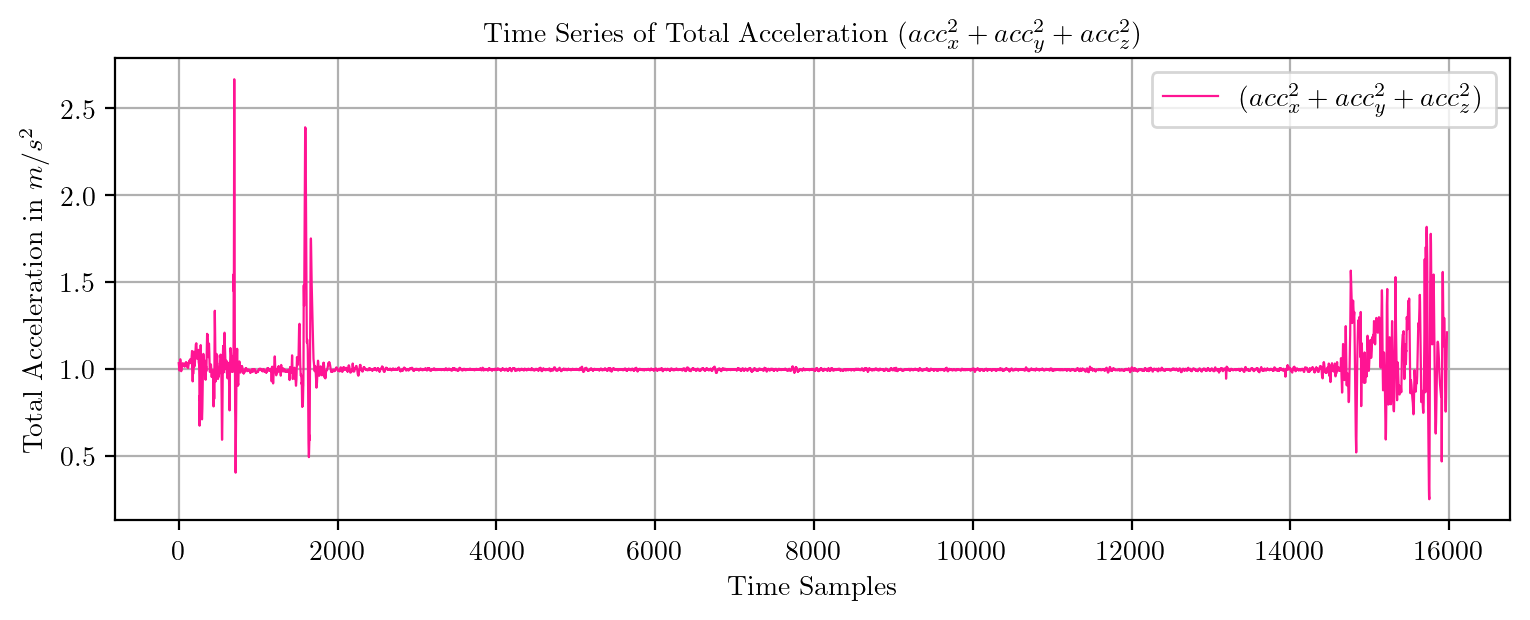

In [40]:
PredictPlot("TS9Sitting.csv", 1)

Trimmed Time Series


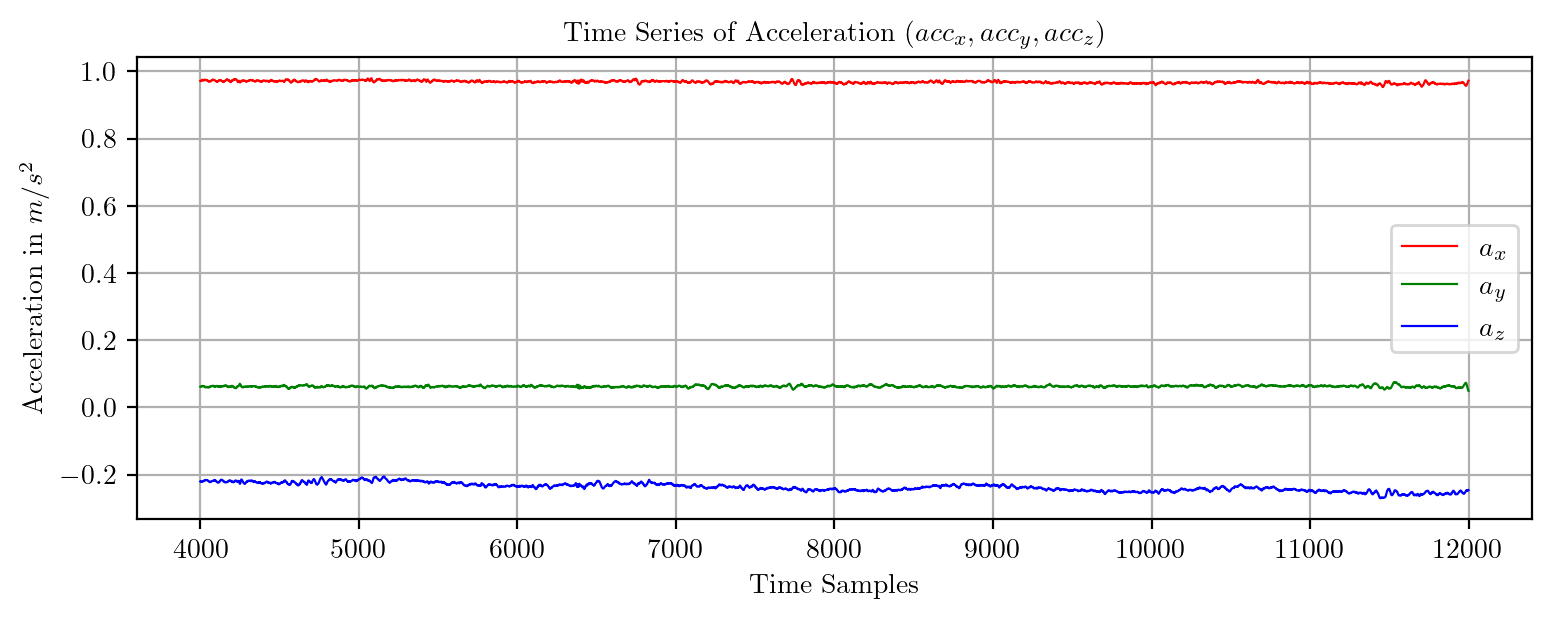

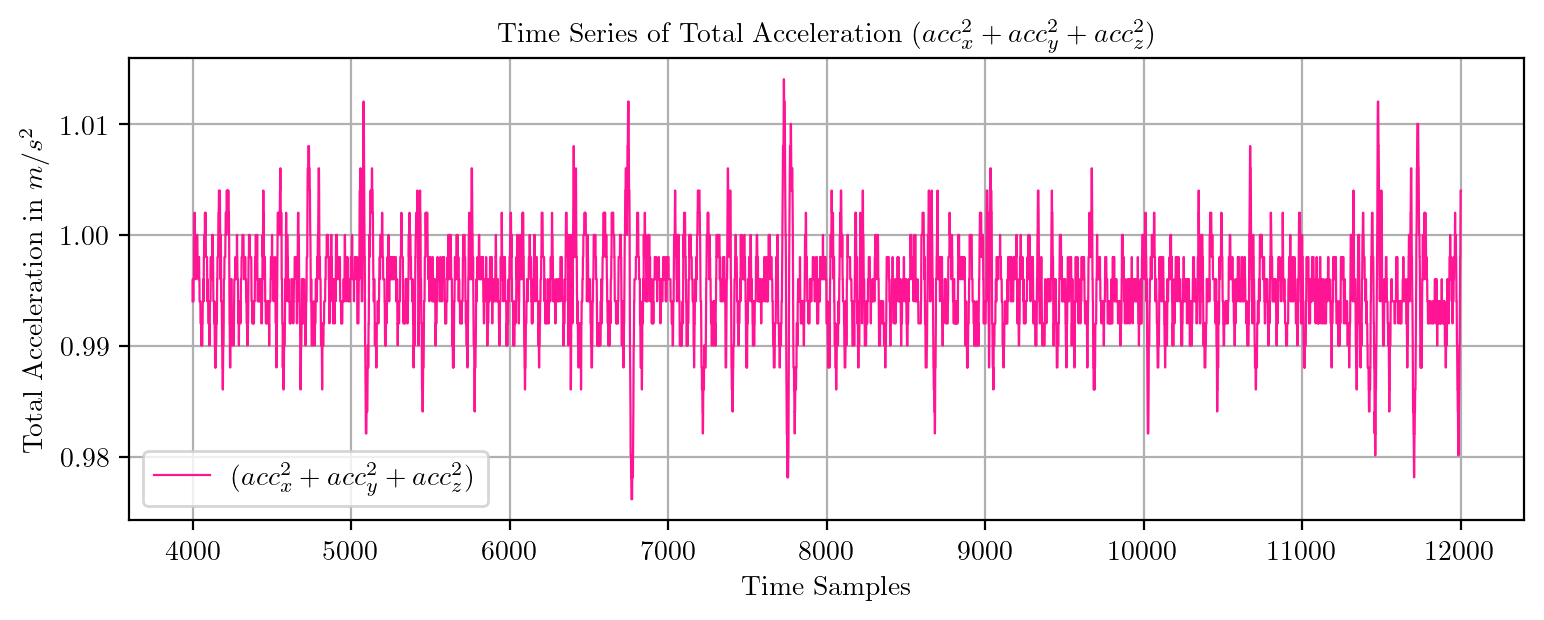

*** Feature extraction started ***



*** Feature extraction finished ***
SITTING


In [49]:
PredictPlot("TS9Sitting.csv", 0, 4000, 12000)

Original Time Series


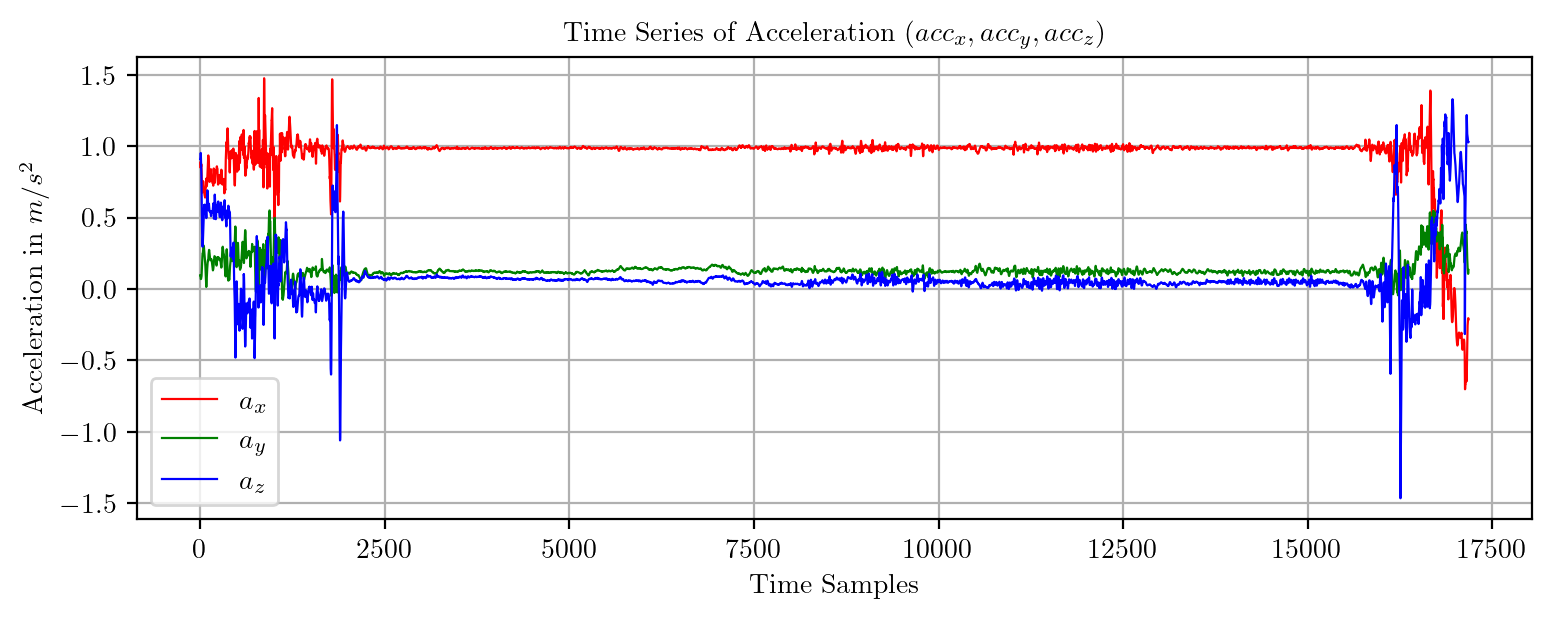

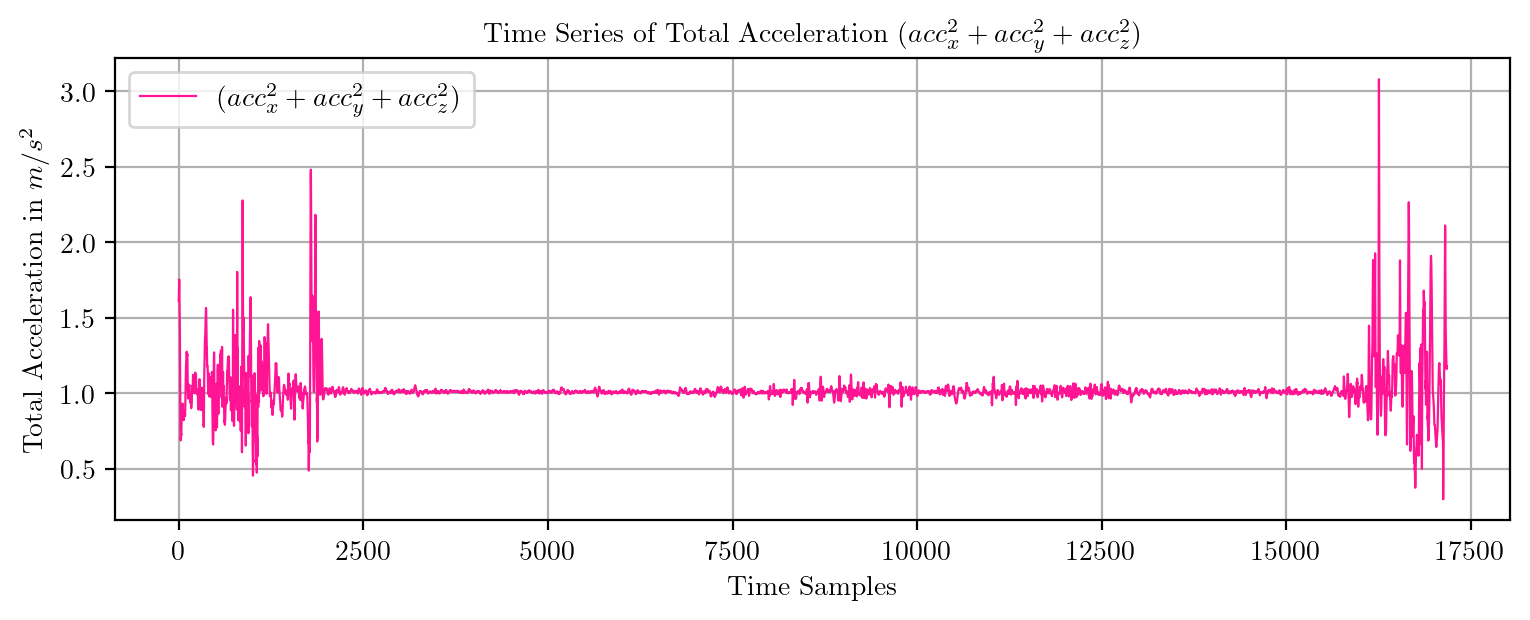

In [41]:
PredictPlot("TS11Standing.csv", 1)

Trimmed Time Series


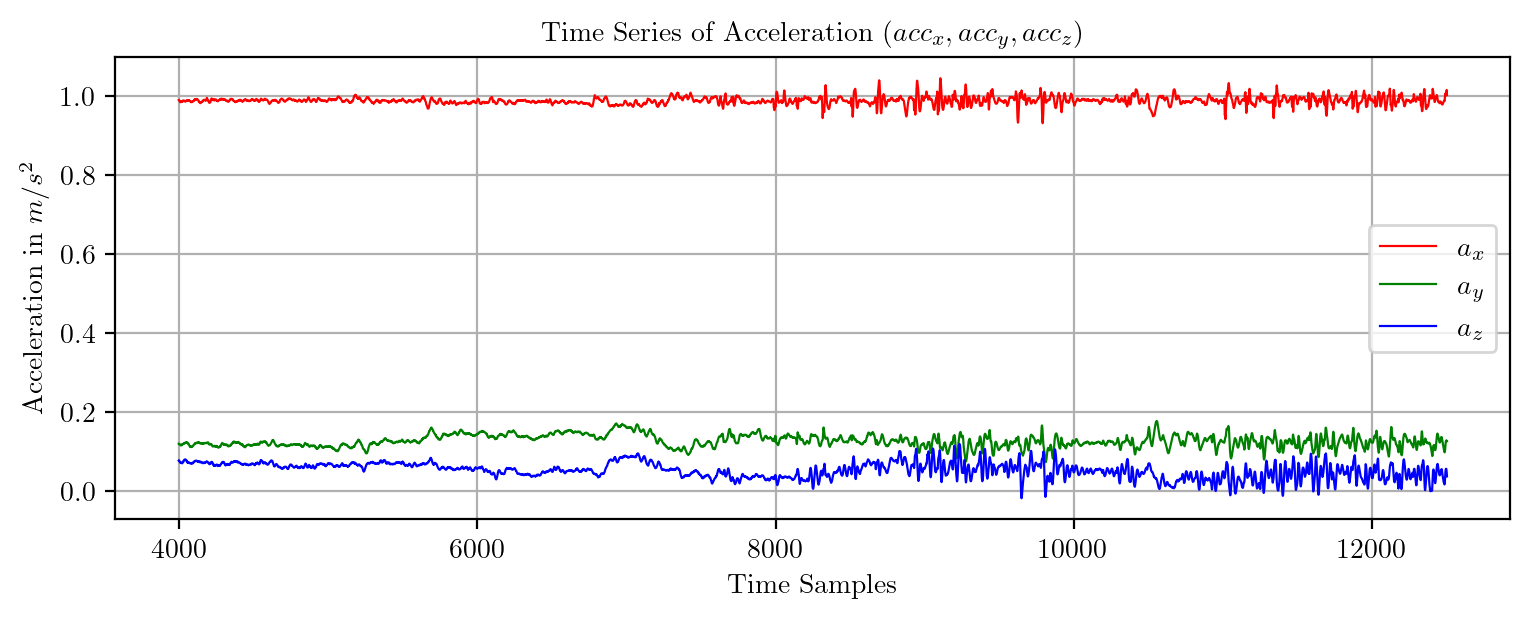

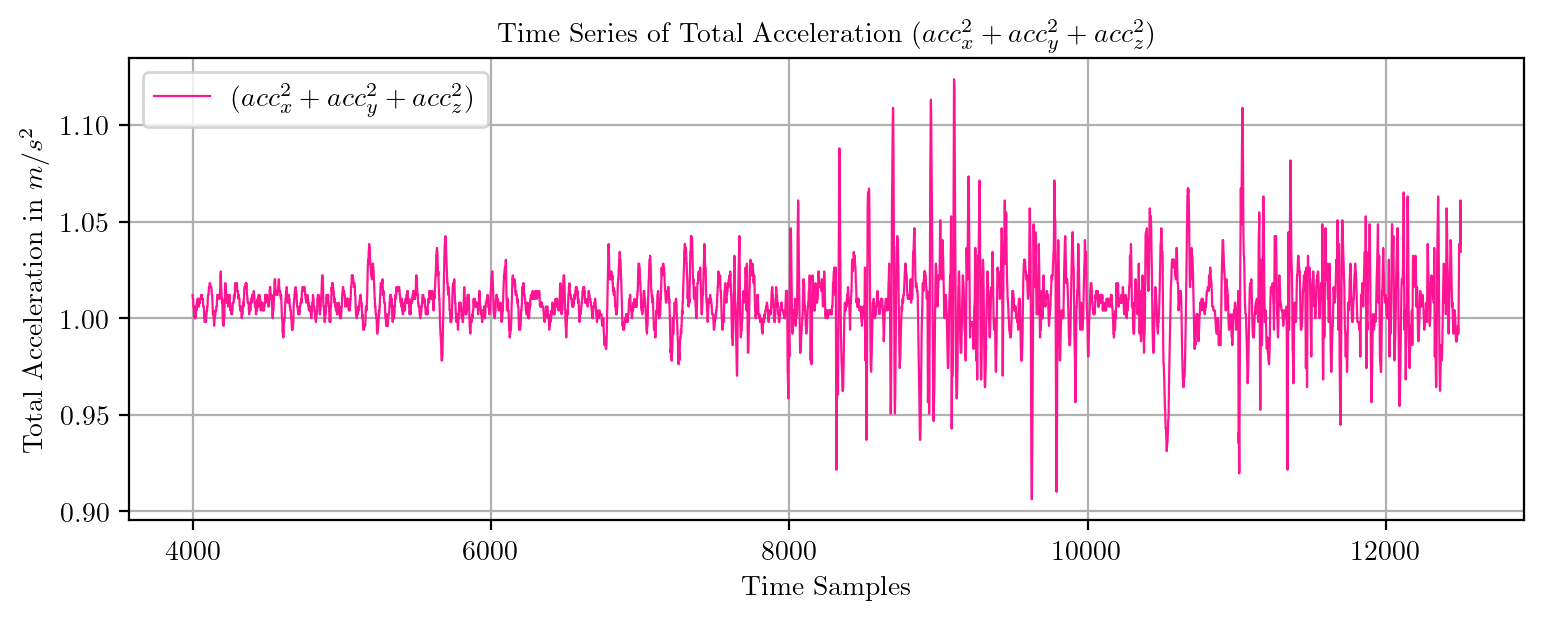

*** Feature extraction started ***



*** Feature extraction finished ***
SITTING


In [42]:
PredictPlot("TS11Standing.csv", 0, 4000, 12500)

Original Time Series


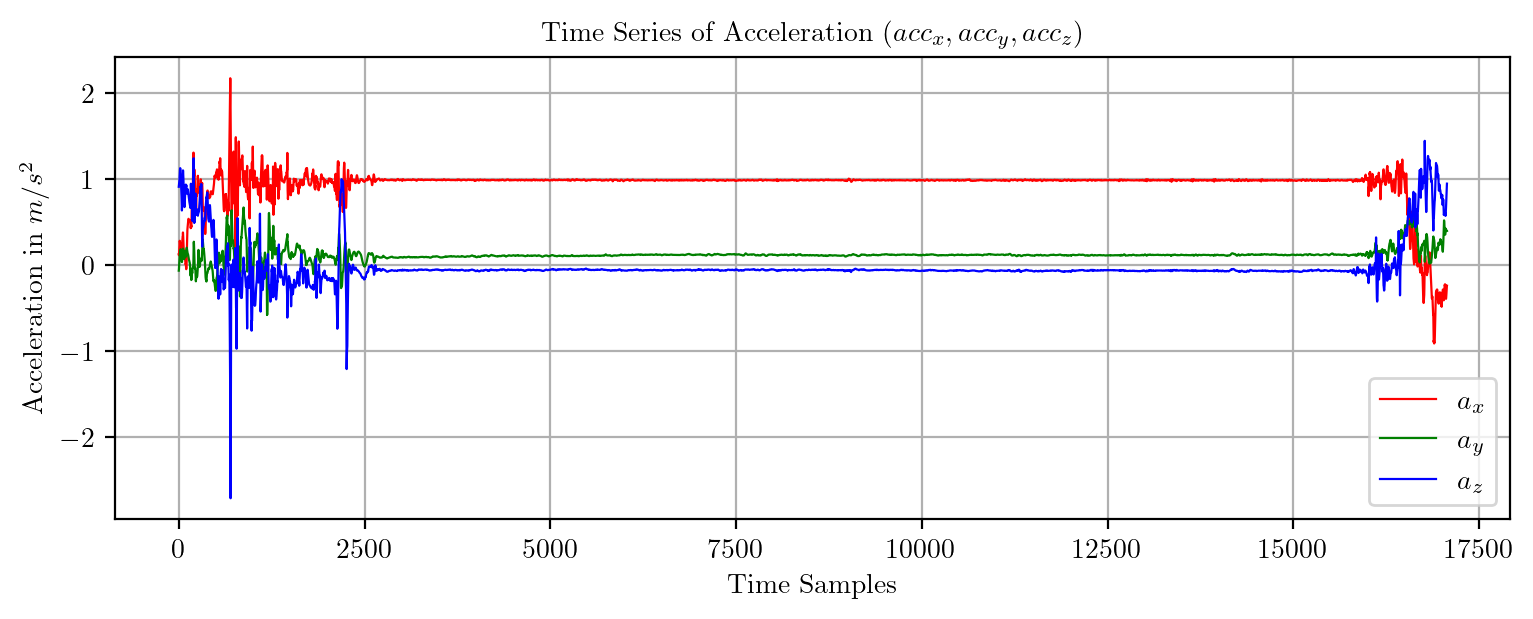

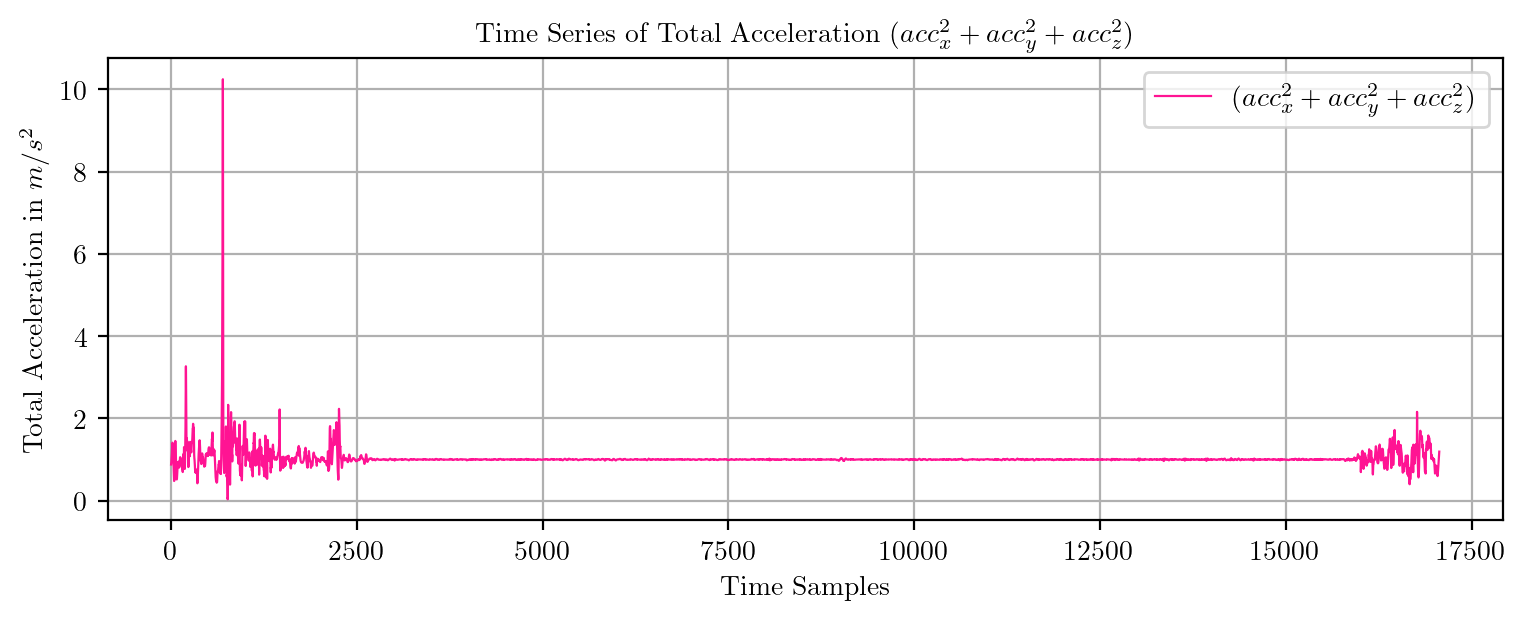

In [43]:
PredictPlot("TS12Standing.csv", 1)

Trimmed Time Series


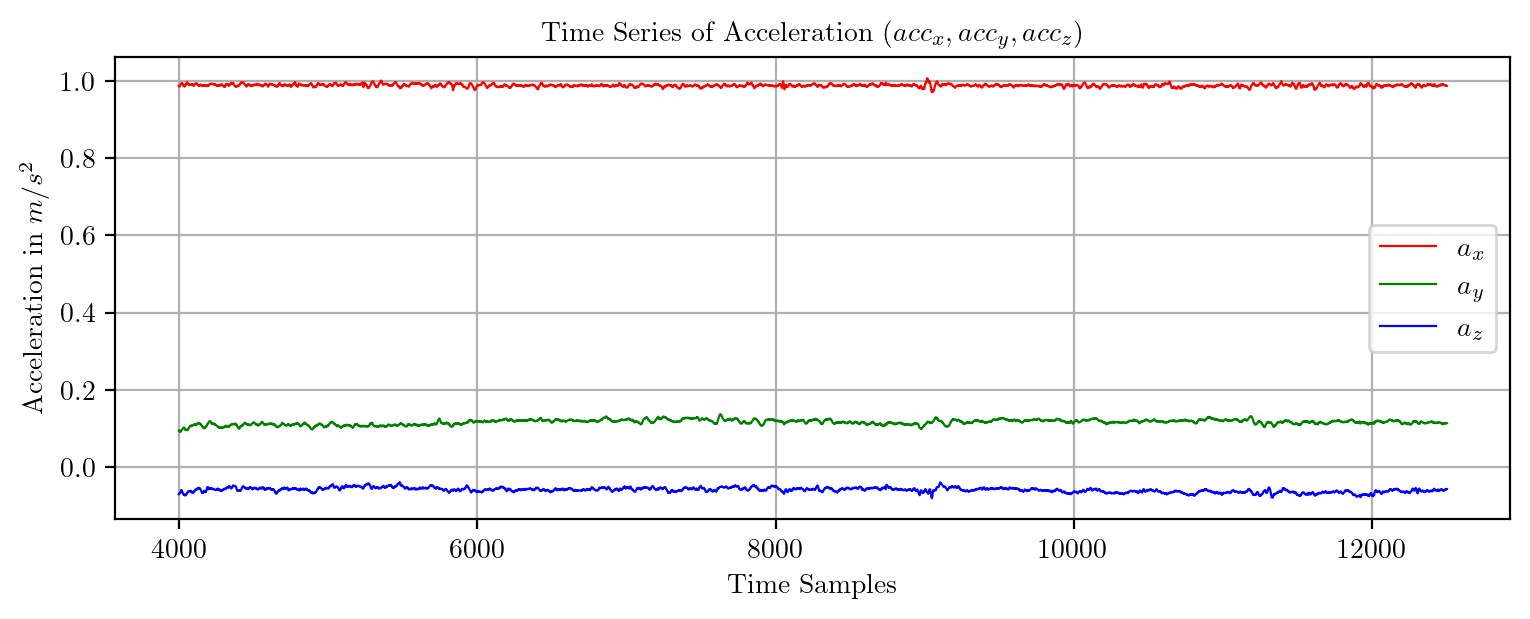

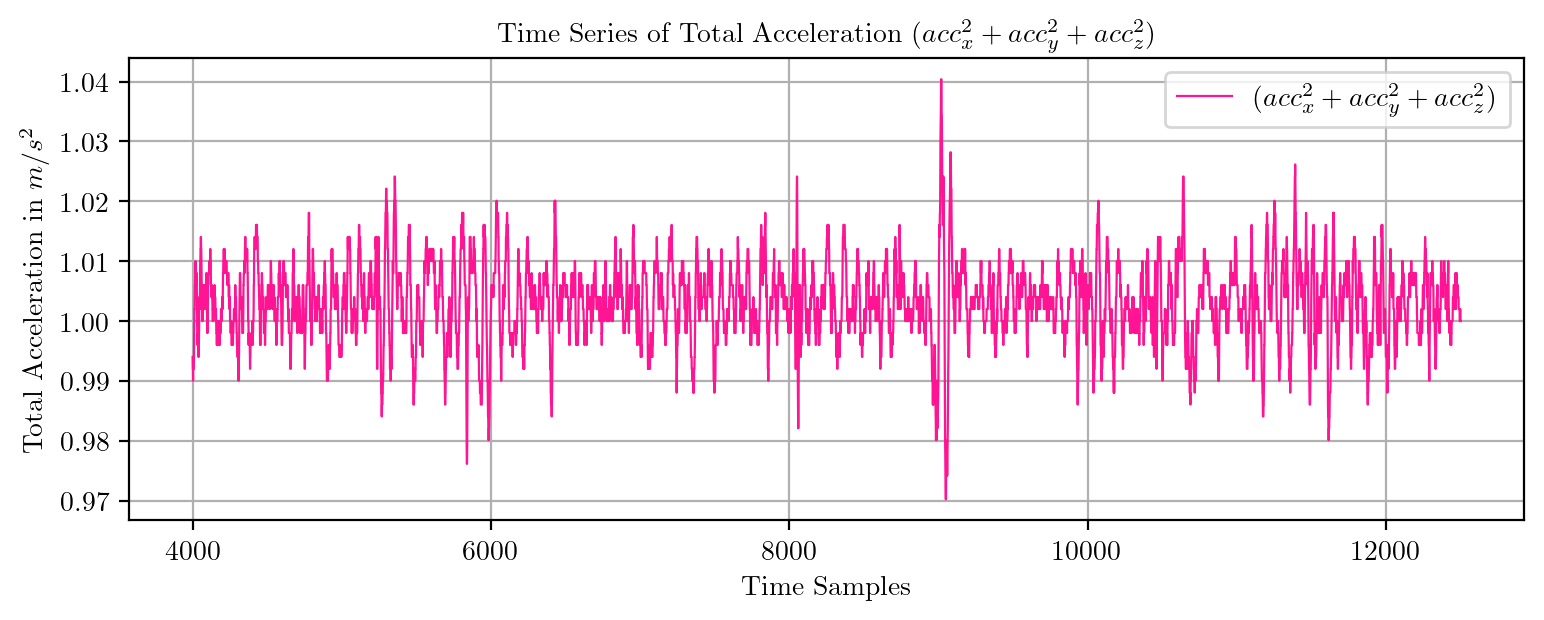

*** Feature extraction started ***



*** Feature extraction finished ***
SITTING


In [44]:
PredictPlot("TS12Standing.csv", 0, 4000, 12500)

Original Time Series


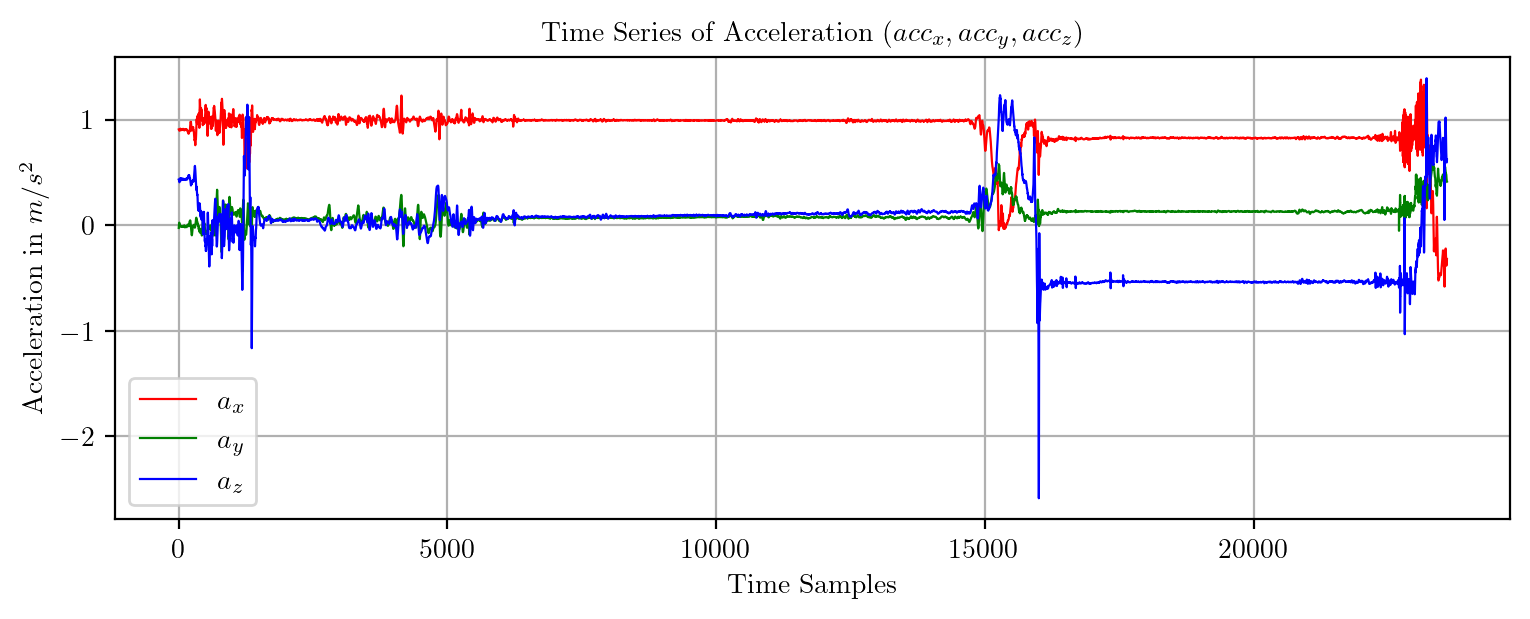

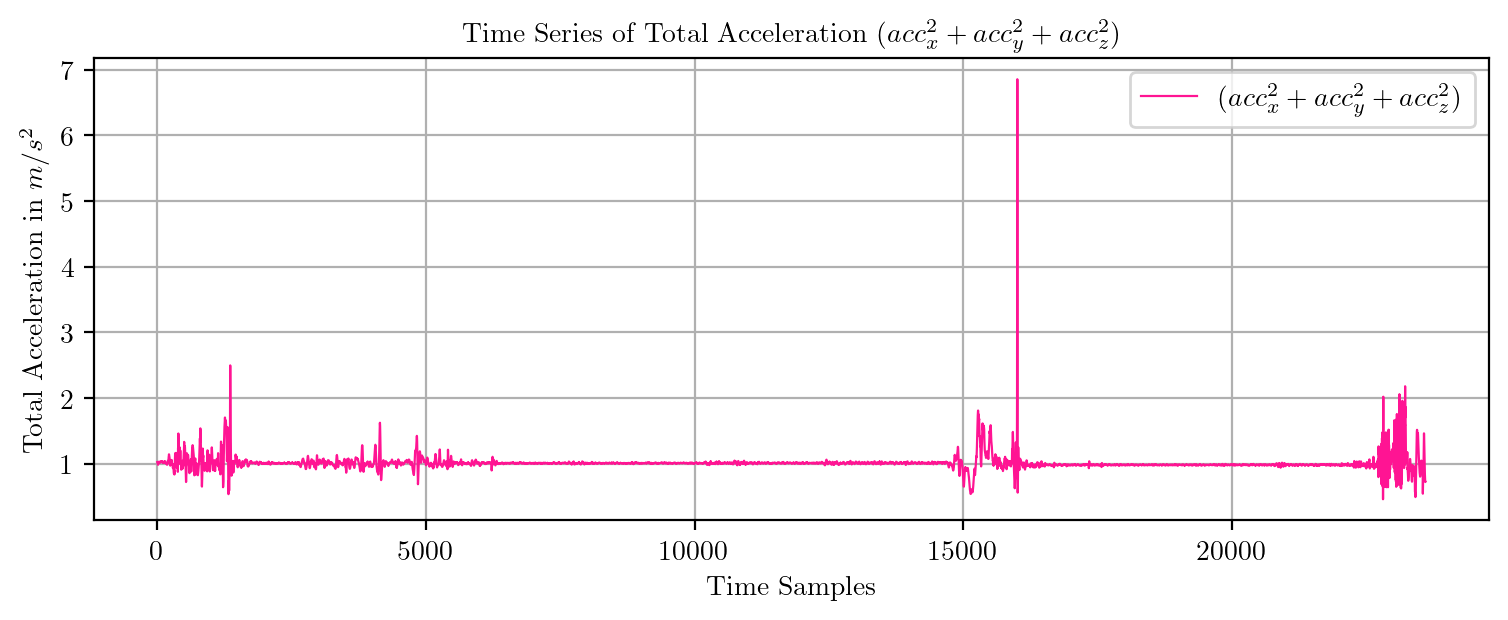

In [45]:
PredictPlot("TS13SittingStanding.csv", 1)

Trimmed Time Series


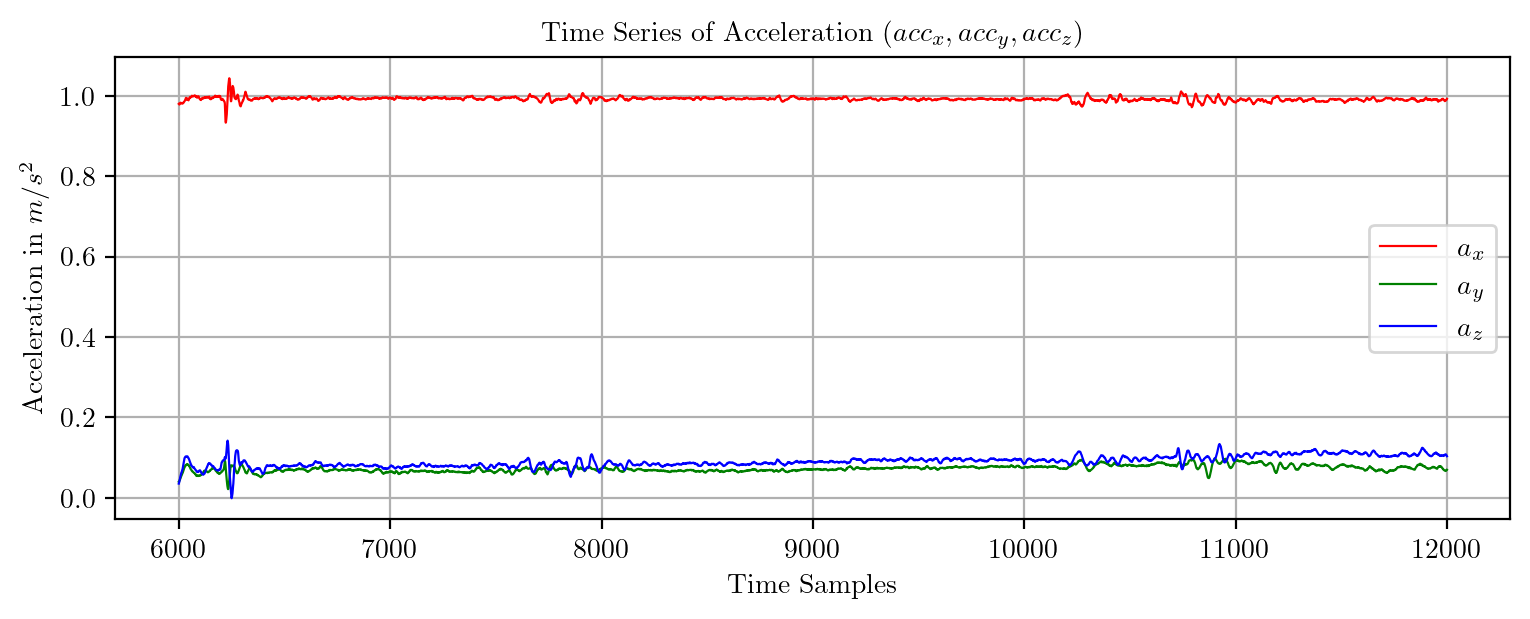

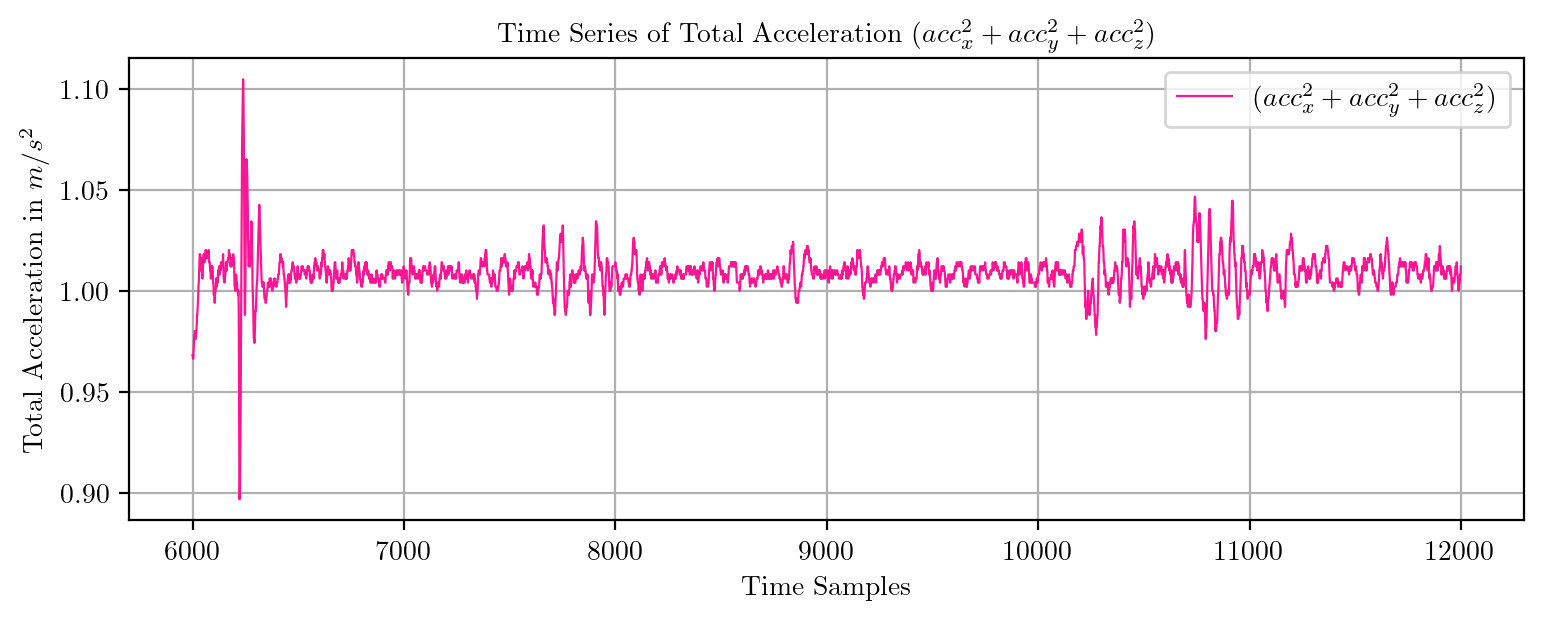

*** Feature extraction started ***



*** Feature extraction finished ***
SITTING


In [46]:
PredictPlot("TS13SittingStanding.csv", 0, 6000, 12000)

Trimmed Time Series


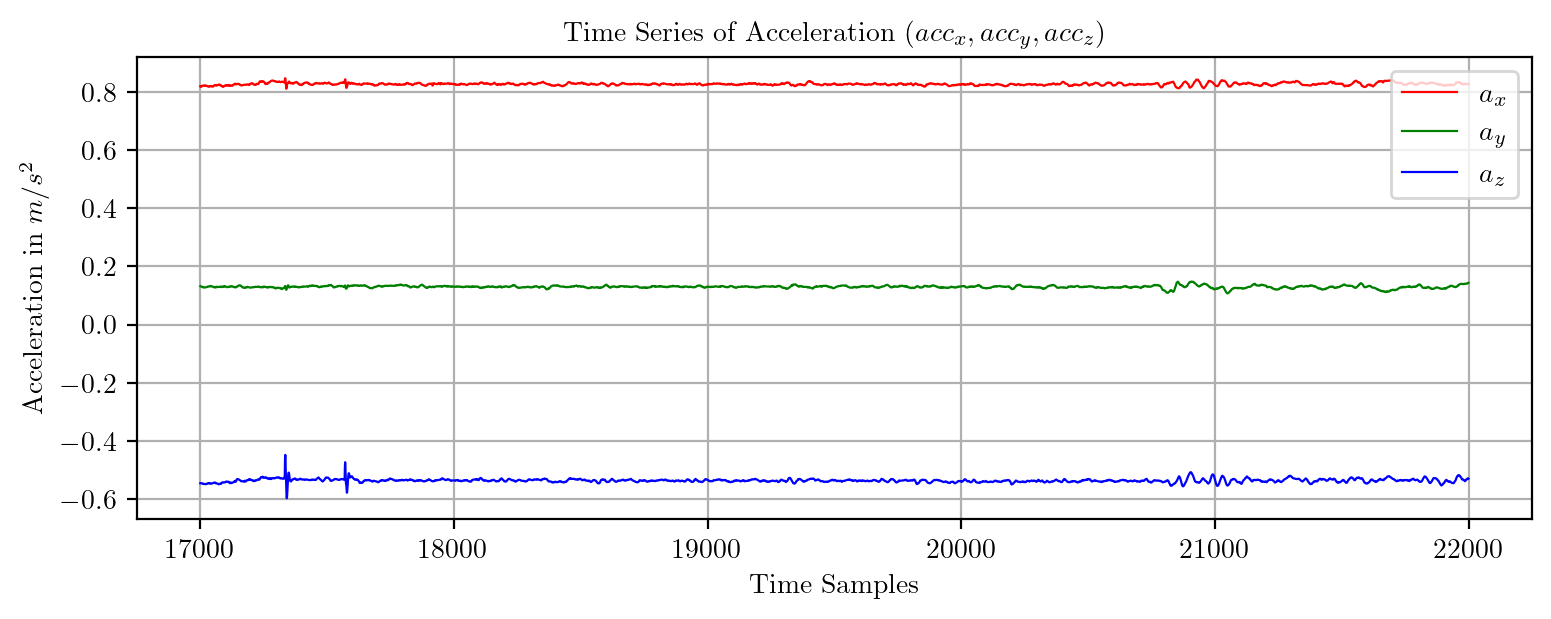

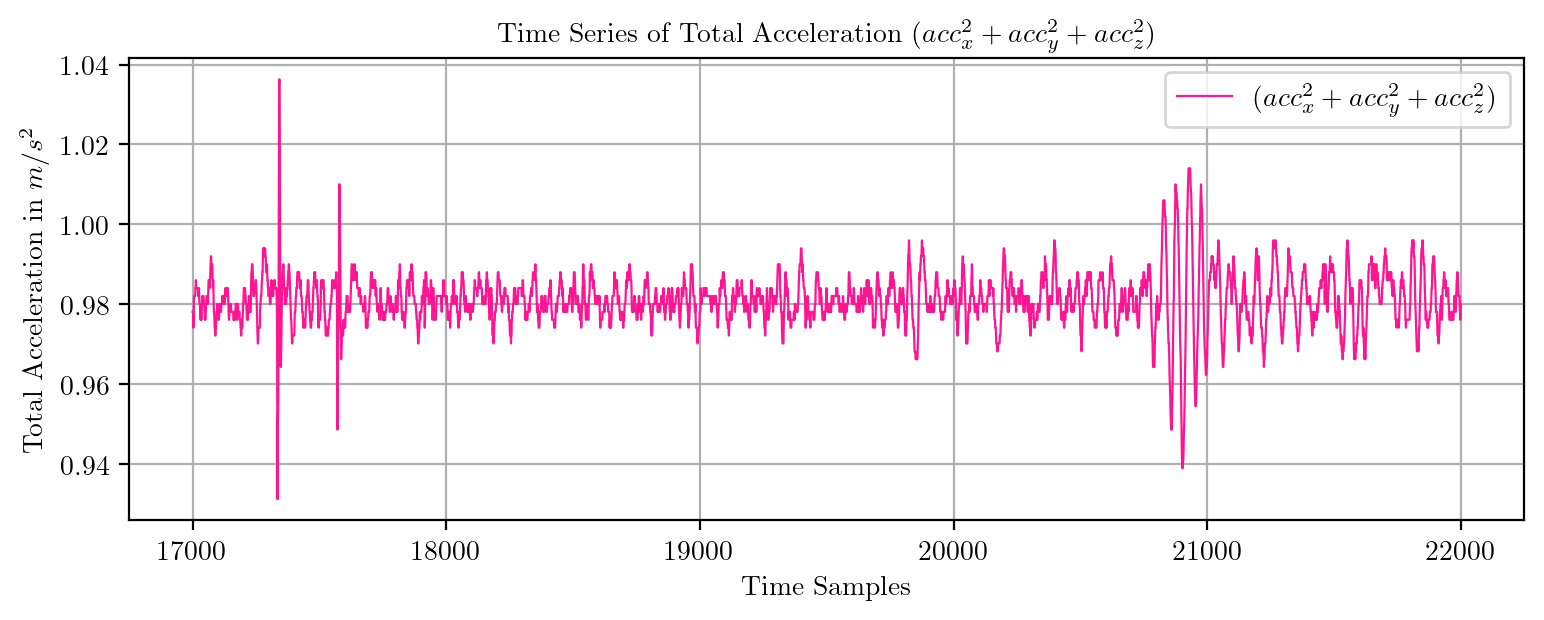

*** Feature extraction started ***



*** Feature extraction finished ***
LAYING


In [47]:
PredictPlot("TS13SittingStanding.csv", 0, 17000, 22000)

Original Time Series


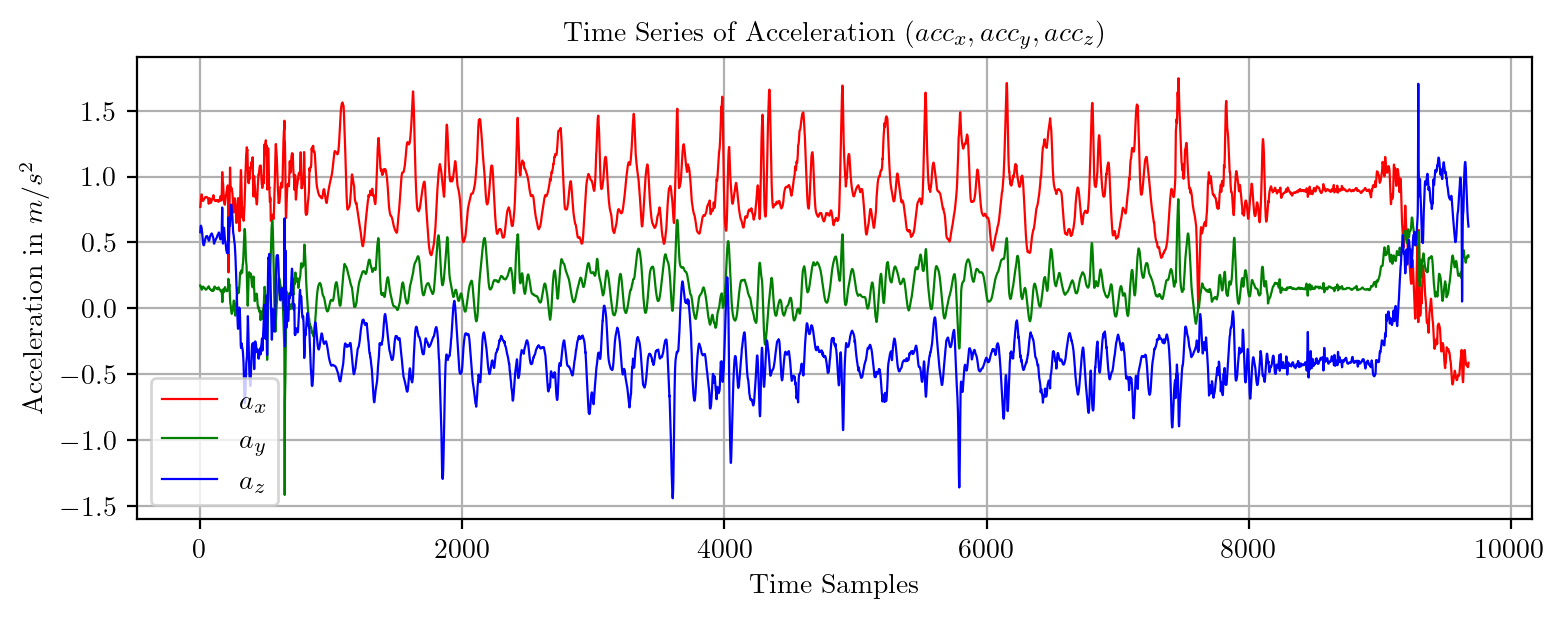

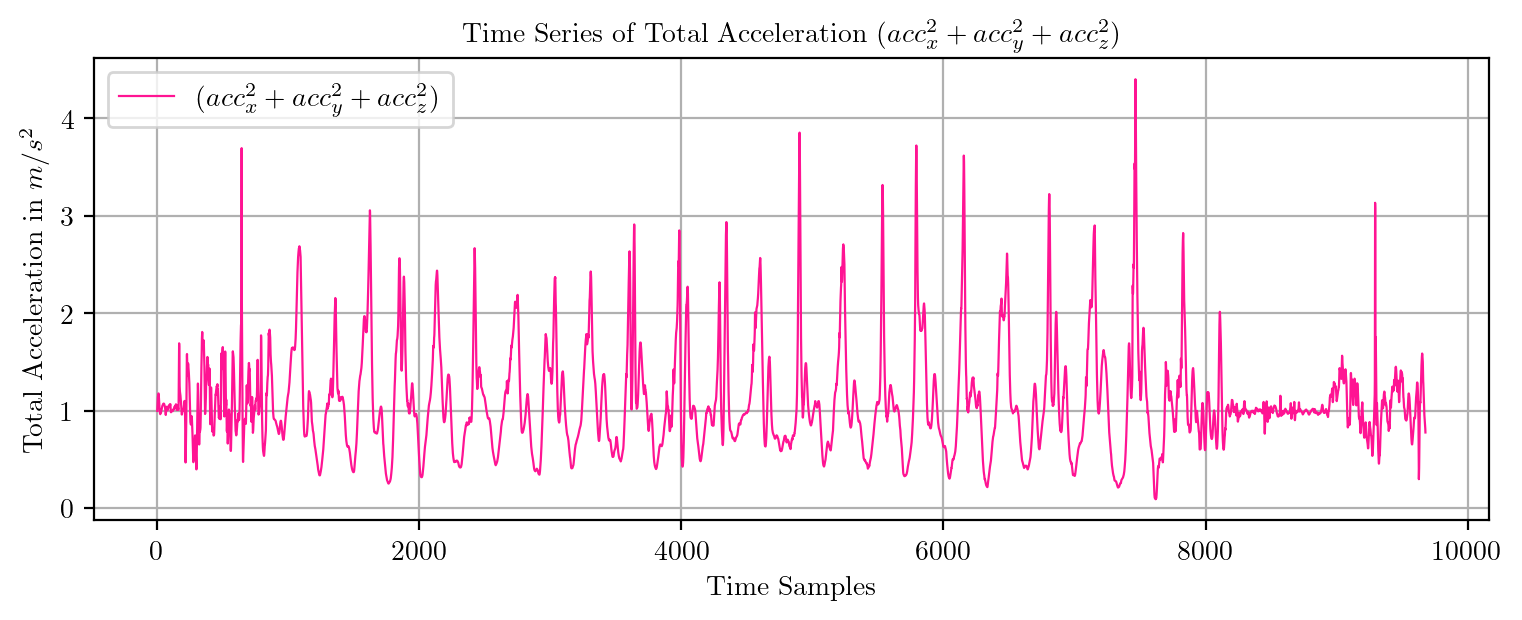

In [48]:
PredictPlot("TS14WalkingUpstairs.csv", 1)

Trimmed Time Series


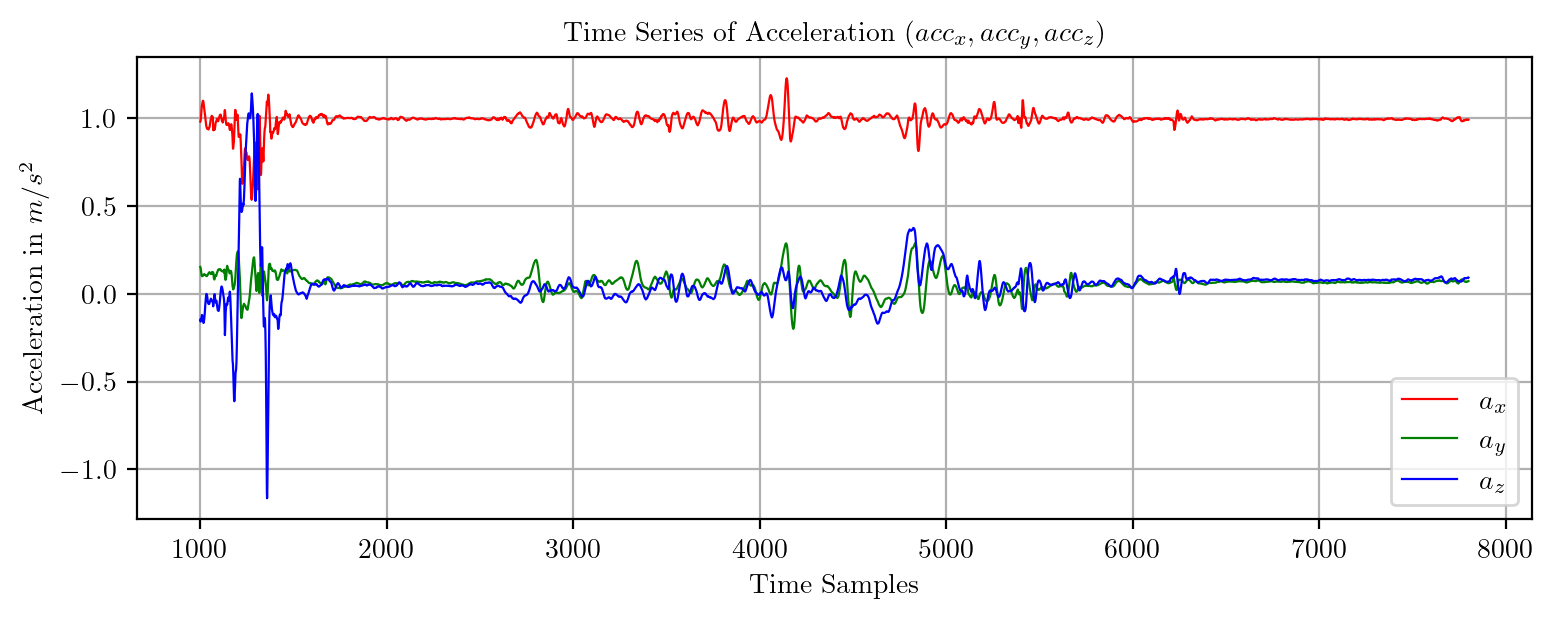

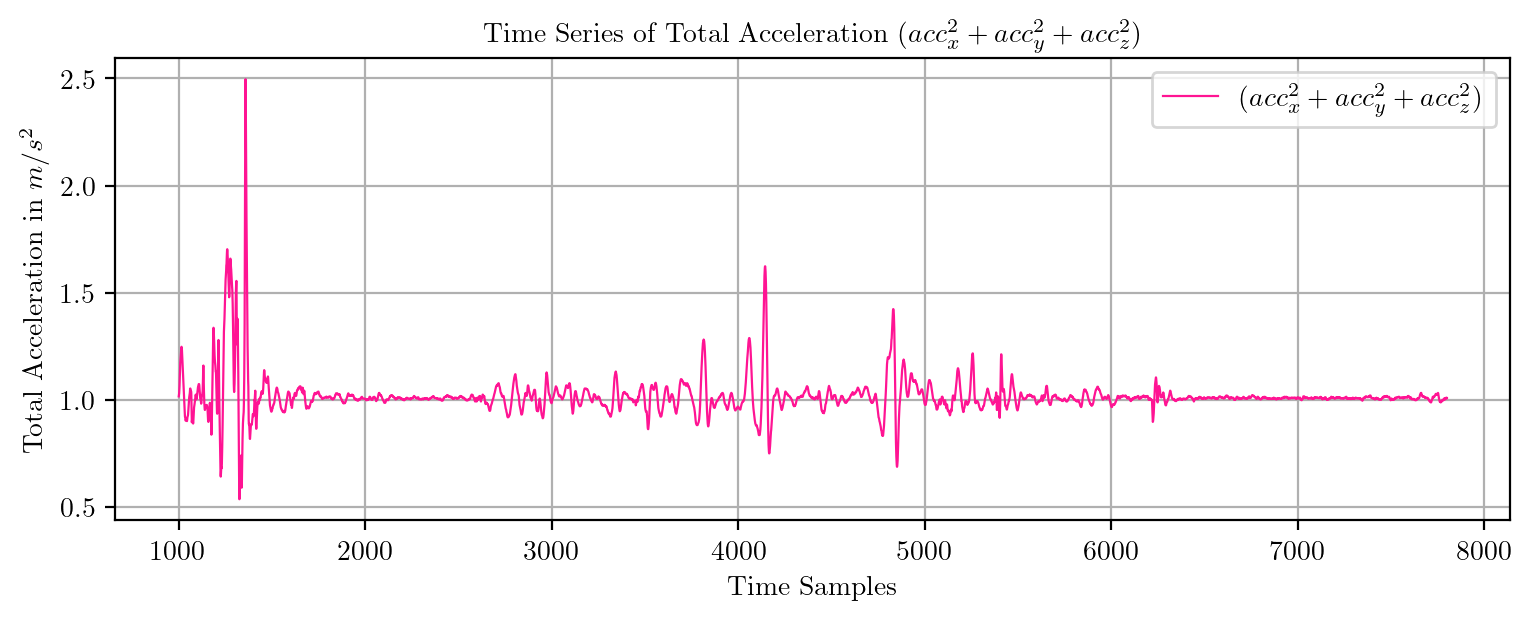

*** Feature extraction started ***



*** Feature extraction finished ***
WALKING


In [61]:
PredictPlot("TS13SittingStanding.csv", 0, 1000, 7800)

Original Time Series


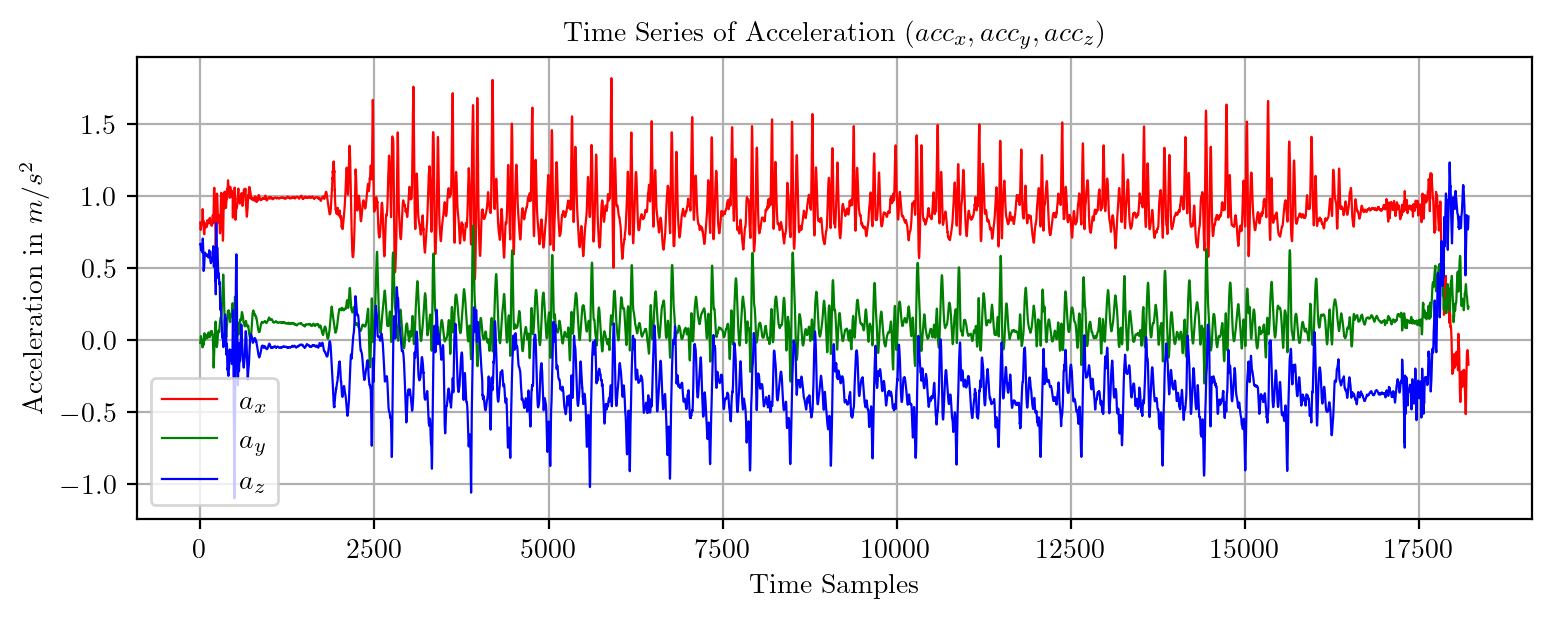

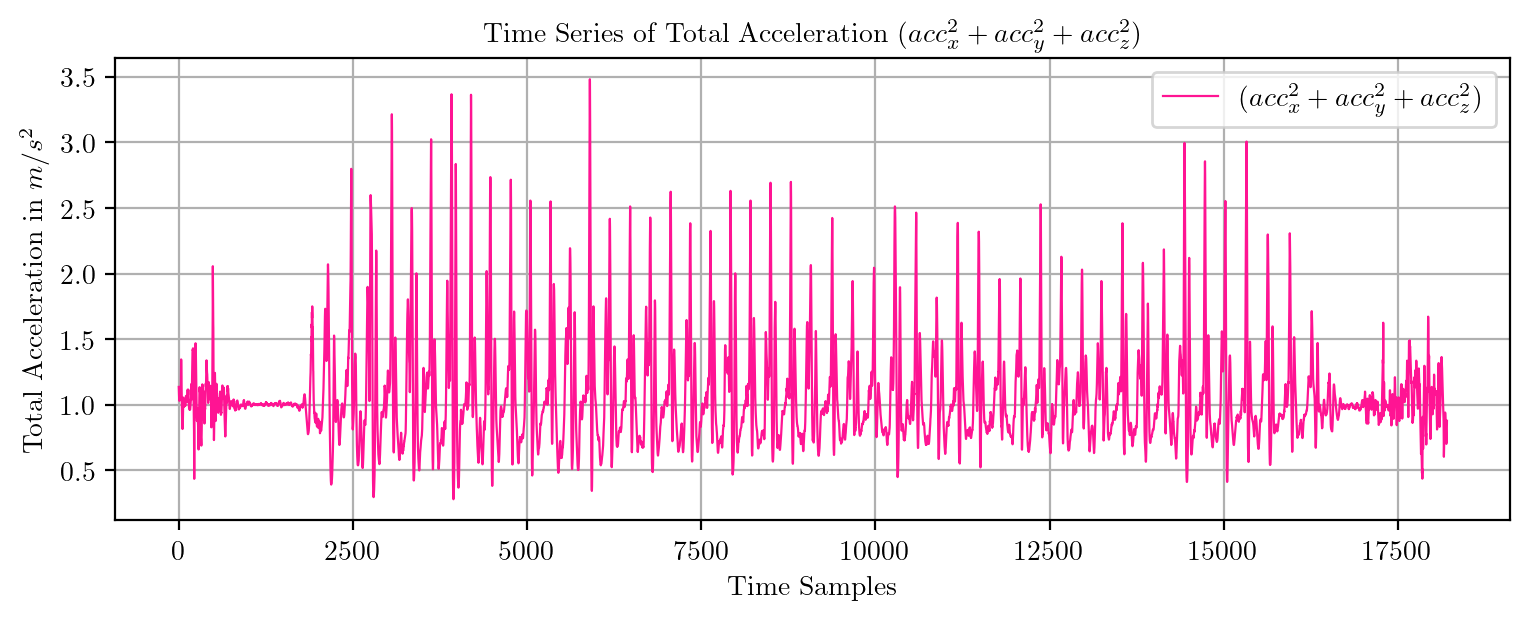

In [49]:
PredictPlot("TS15Walking.csv", 1)

Trimmed Time Series


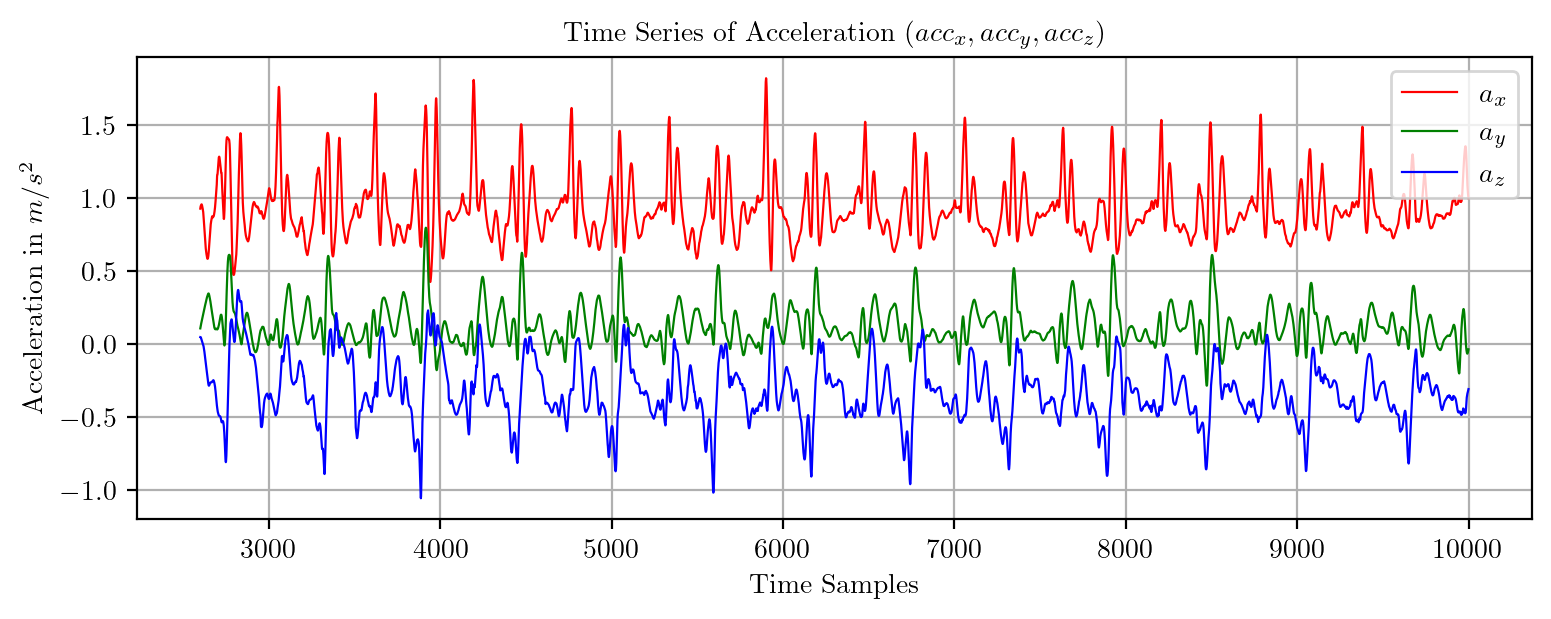

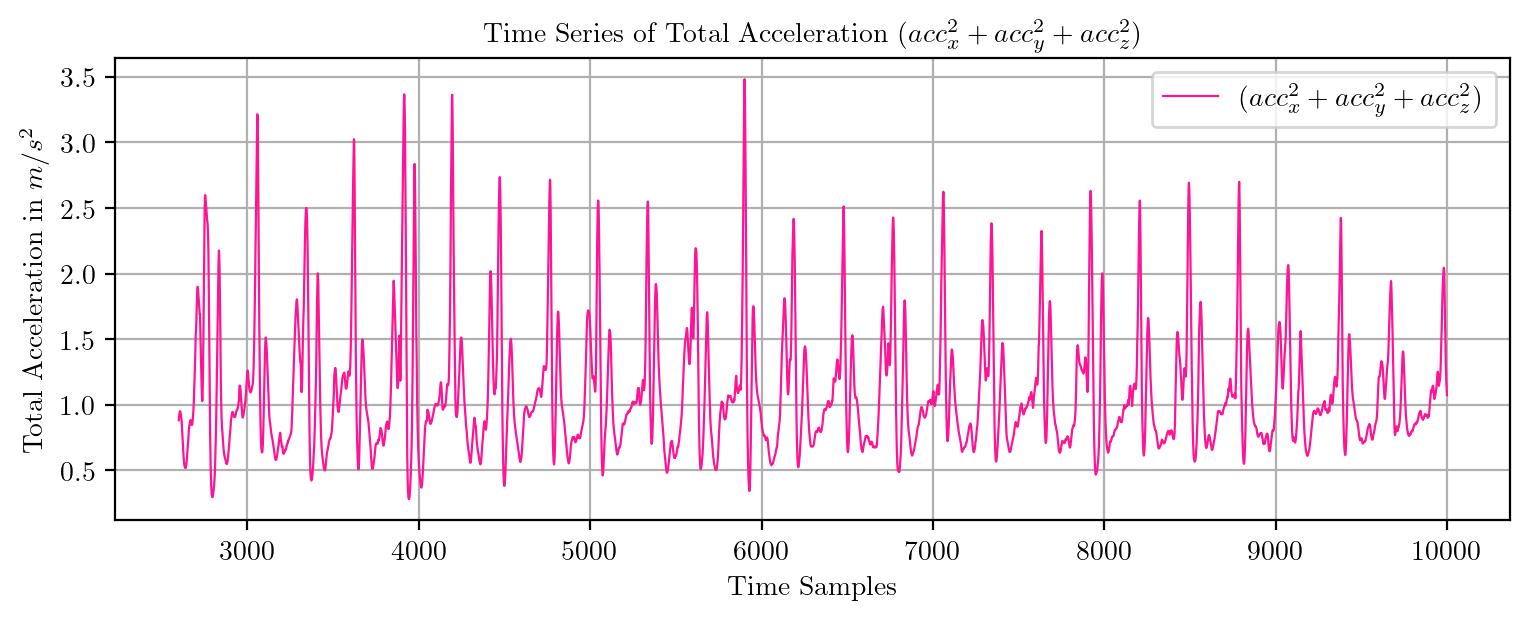

*** Feature extraction started ***



*** Feature extraction finished ***
WALKING


In [50]:
PredictPlot("TS15Walking.csv", 0, 2600, 10000)

Original Time Series


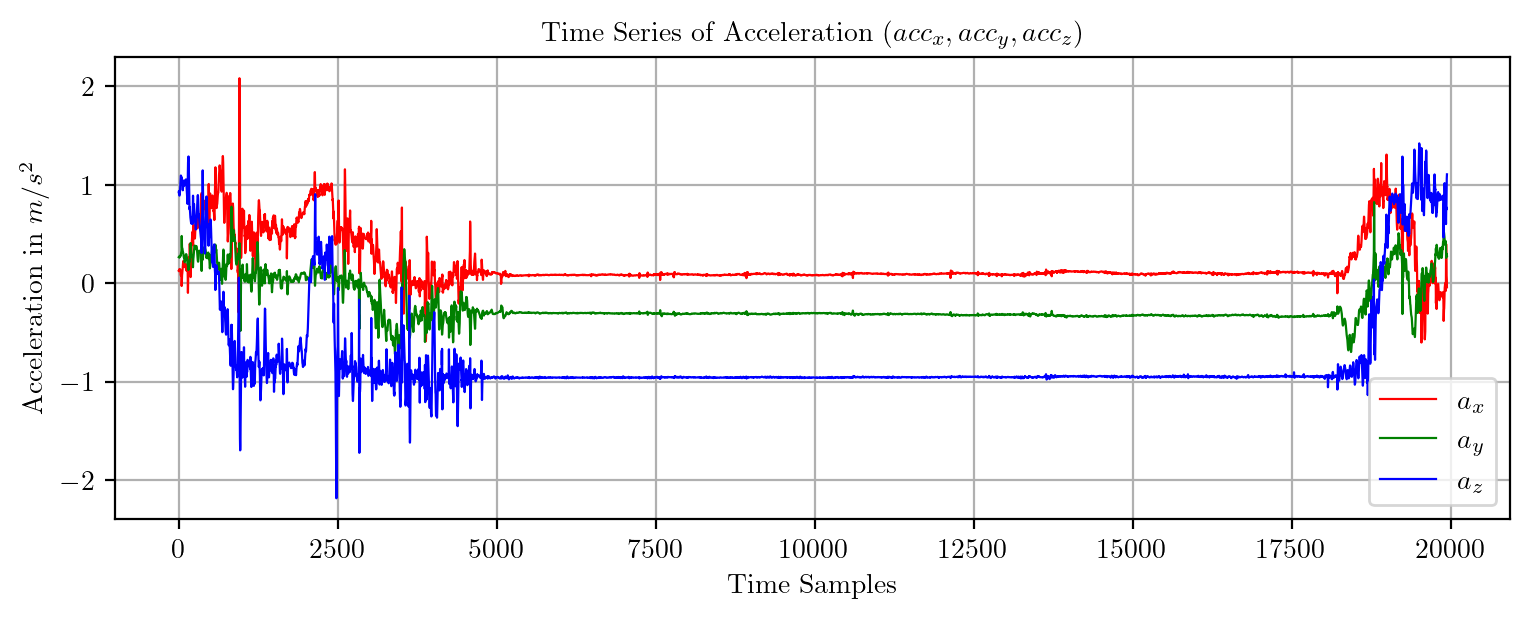

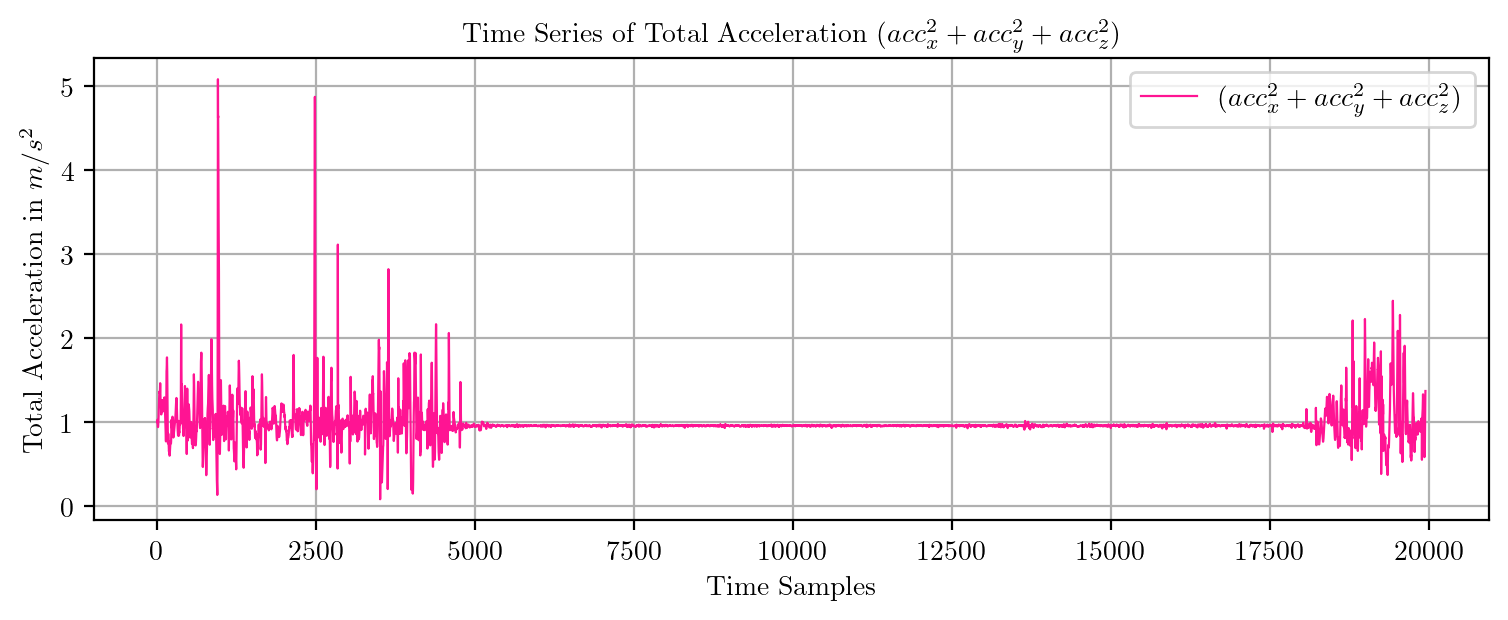

In [51]:
PredictPlot("TS16Laying.csv", 1)

Trimmed Time Series


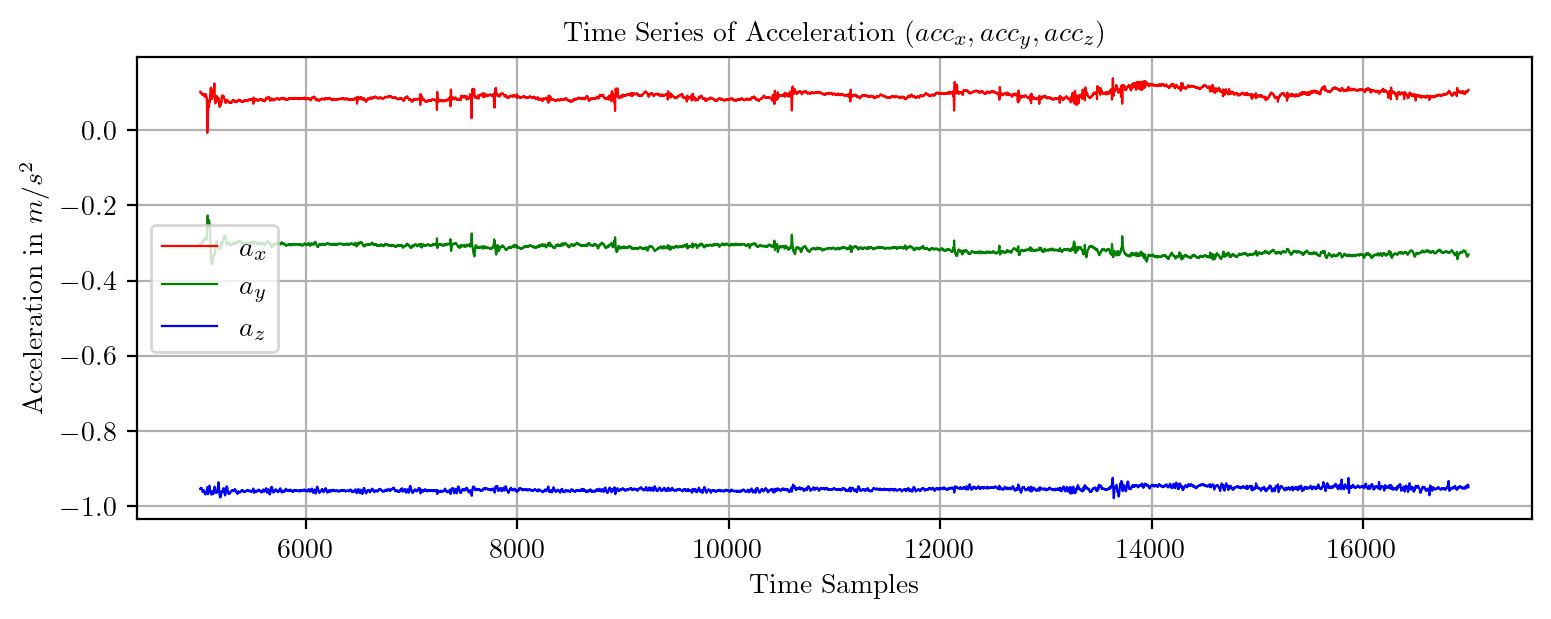

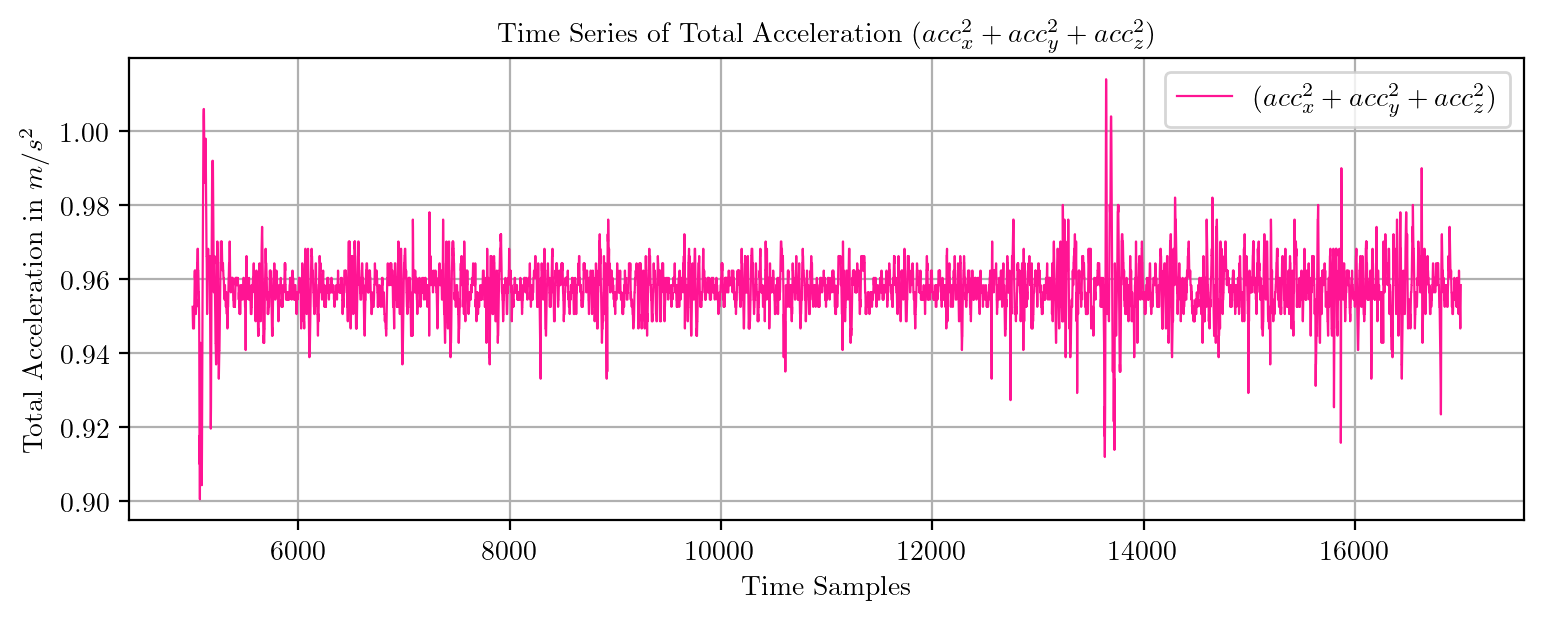

*** Feature extraction started ***



*** Feature extraction finished ***
LAYING


In [52]:
PredictPlot("TS16Laying.csv", 0, 5000, 17000)